Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=14
num_BackTrack_Days=0

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=443 => 15/04/2021
#
drop_n_dataset_days=447
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
249                                           NaN             Timor-Leste   
250                                           NaN                    Togo   
251                                           NaN     Trinidad and Tobago   
252                                           NaN                 Tunisia   
253                                           NaN                  Turkey   
254                                           NaN           United States   
255                                           NaN                  Uganda   
256                                           NaN                 Ukraine   
257                                           NaN    United Arab Emirates   
258                                      Anguilla          United Kingdom   
259                                       Bermuda          United Kingdom   
260                        British Virgin Islands          United Kingdom   
261                                Cayman Islands          United Kingdom   
262                               Channel Islands          United Kingdom   
263                   Falkland Islands (Malvinas)          United Kingdom   
264                                     Gibraltar          United Kingdom   
265                                   Isle of Man          United Kingdom   
266                                    Montserrat          United Kingdom   
267  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
268                      Turks and Caicos Islands          United Kingdom   
269                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
255                                           NaN             Timor-Leste   
256                                           NaN                    Togo   
257                                           NaN     Trinidad and Tobago   
258                                           NaN                 Tunisia   
259                                           NaN                  Turkey   
260                                           NaN           United States   
261                                           NaN                  Uganda   
262                                           NaN                 Ukraine   
263                                           NaN    United Arab Emirates   
264                                      Anguilla          United Kingdom   
265                                       Bermuda          United Kingdom   
266                        British Virgin Islands          United Kingdom   
267                                Cayman Islands          United Kingdom   
268                               Channel Islands          United Kingdom   
269                   Falkland Islands (Malvinas)          United Kingdom   
270                                     Gibraltar          United Kingdom   
271                                   Isle of Man          United Kingdom   
272                                    Montserrat          United Kingdom   
273  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
274                      Turks and Caicos Islands          United Kingdom   
275                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  10/10/21  10/11/21  10/12/21  \
185        0        0        0        0  ...       459       459       459   
186        0        0        0        0  ...         0         0         0   
187        0        0        0        0  ...       785       785       785   
188        0        0        0        0  ...       106       110       115   
189        0        0        0        0  ...    282086    282227    282773   
190        0        0        0        0  ...         0         0         0   
191        0        0        0        0  ...      7024      7048      7076   
192        0        0        0        0  ...        35        35        35   
193        0        0        0        0  ...      1450      1450      1482   
194        0        0        0        0  ...      1986      1992      2000   

     10/13/21  10/14/21  10/15/21  10/16/21  10/17/21   Population   \
185       459       459       459       459       459       441,543   
186         0         0         0         0         0           NaN   
187       785       786       787       788       788     4,649,658   
188       123       123       129       129       129     1,273,985   
189    283193    283574    284008    284321    284381   128,640,794   
190         0         0         0         0         0           NaN   
191      7105      7137      7172      7206      7241     4,035,942   
192        35        35        35        35        35        39,183   
193      1497      1497      1527      1527      1556     3,278,290   
194      2005      2010      2018      2020      2023       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 641 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN         Monaco  43.733300    7.41670   
176                               NaN       Mongolia  46.862500  103.84670   
177                               NaN     Montenegro  42.708678   19.37439   
178                               NaN        Morocco  31.791700   -7.09260   
179                               NaN     Mozambique -18.665700   35.52960   
180                               NaN        Namibia -22.957600   18.49040   
181                               NaN          Nepal  28.166700   84.25000   
182                             Aruba    Netherlands  12.521100  -69.96830   
183  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   
184                           Curacao    Netherlands  12.169600  -68.99000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/10/21  \
175        0        0        0        0        0        0  ...         0   
176        0        0        0        0        0        0  ...         0   
177        0        0        0        0        0        0  ...         0   
178        0        0        0        0        0        0  ...         0   
179        0        0        0        0        0        0  ...         0   
180        0        0        0        0        0        0  ...         0   
181        0        0        0        0        0        0  ...         0   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...         0   
184        0        0        0        0        0        0  ...         0   

     10/11/21  10/12/21  10/13/21  10/14/21  10/15/21  10/16/21  10/17/21  \
175         0         0         0         0         0         0         0   
176         0         0         0         0         0         0         0   
177         0         0         0         0         0         0         0   
178         0         0         0         0         0         0         0   
179         0         0         0         0         0         0         0   
180         0         0         0         0         0         0         0   
181         0         0         0         0         0         0         0   
182         0         0         0         0         0         0         0   
183         0         0         0         0         0         0         0   
184         0         0         0         0         0         0         0   

      Population                                         region  
175        39,183                                    Monaco_nan  
176     3,278,290                                  Mongolia_nan  
177       622 500                                Montenegro_nan  
178    36,817,128                                   Morocco_nan  
179    31,542,919                                Mozambique_nan  
180     2,540,905                                   Namibia_nan  
181    29,300,000                                     Nepal_nan  
182       116,600                             Netherlands_Aruba  
183        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  
184       158,665                           Netherlands_Curacao  

[10 rows x 641 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  10/10/21  10/11/21  10/12/21  \
185        0        0        0        0  ...     37347     37358     37375   
186        0        0        0        0  ...         4         4         4   
187        0        0        0        0  ...     36414     36432     36465   
188        0        0        0        0  ...     16189     16291     16437   
189        0        0        0        0  ...   3723235   3725242   3732429   
190        0        0        0        0  ...         1         1         1   
191        0        0        0        0  ...    306647    307182    308724   
192        0        0        0        0  ...      3335      3336      3337   
193        0        0        0        0  ...    326738    326738    330869   
194        0        0        0        0  ...    135298    135533    135981   

     10/13/21  10/14/21  10/15/21  10/16/21  10/17/21   Population   \
185     37393     37412     37437     37445     37453       441,543   
186         4         4         4         4         4           NaN   
187     36509     36550     36591     36645     36677     4,649,658   
188     16472     16472     16621     16621     16621     1,273,985   
189   3738749   3744574   3749860   3755063   3757056   128,640,794   
190         1         1         1         1         1           NaN   
191    310776    312442    313849    315414    316529     4,035,942   
192      3337      3354      3357      3358      3358        39,183   
193    332789    332789    336508    336508    339536     3,278,290   
194    136322    136681    137046    137401    137769       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 641 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                          Portugal  39.399900   -8.224500   
221            NaN                             Qatar  25.354800   51.183900   
222            NaN                           Romania  45.943200   24.966800   
223            NaN                            Russia  61.524010  105.318756   
224            NaN                            Rwanda  -1.940300   29.873900   
225            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
226            NaN                       Saint Lucia  13.909400  -60.978900   
227            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
228            NaN                             Samoa -13.759000 -172.104600   
229            NaN                        San Marino  43.942400   12.457800   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/10/21  \
220        0        0        0        0        0        0  ...   1075312   
221        0        0        0        0        0        0  ...    237424   
222        0        0        0        0        0        0  ...   1356640   
223        0        0        0        0        0        0  ...   7658923   
224        0        0        0        0        0        0  ...     98697   
225        0        0        0        0        0        0  ...      2361   
226        0        0        0        0        0        0  ...     11970   
227        0        0        0        0        0        0  ...      4096   
228        0        0        0        0        0        0  ...         3   
229        0        0        0        0        0        0  ...      5466   

     10/11/21  10/12/21  10/13/21  10/14/21  10/15/21  10/16/21  10/17/21  \
220   1075639   1076358   1077186   1077963   1078729   1079341   1079806   
221    237483    237579    237662    237741    237798    237867    237929   
222   1365788   1382531   1398264   1414647   1430475   1445714   1457260   
223   7687559   7714973   7742899   7773388   7804750   7837101   7870529   
224     98745     98840     98926     98987     99067     99128     99145   
225      2412      2435      2466      2511      2525      2546      2550   
226     12017     12054     12095     12129     12129     12206     12228   
227      4096      4096      4096      4096      4096      4418      4623   
228         3         3         3         3         3         3         3   
229      5470      5470      5470      5470      5473      5473      5473   

      Population                                 region  
220    10,290,000                          Portugal_nan  
221     2,870,256                             Qatar_nan  
222    19,530,000                           Romania_nan  
223   144,500,000                            Russia_nan  
224    12,952,218                            Rwanda_nan  
225        53,673             Saint Kitts and Nevis_nan  
226       184,106                       Saint Lucia_nan  
227       110,940  Saint Vincent and the Grenadines_nan  
228           NaN                             Samoa_nan  
229        33,916                        San Marino_nan  

[10 rows x 641 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

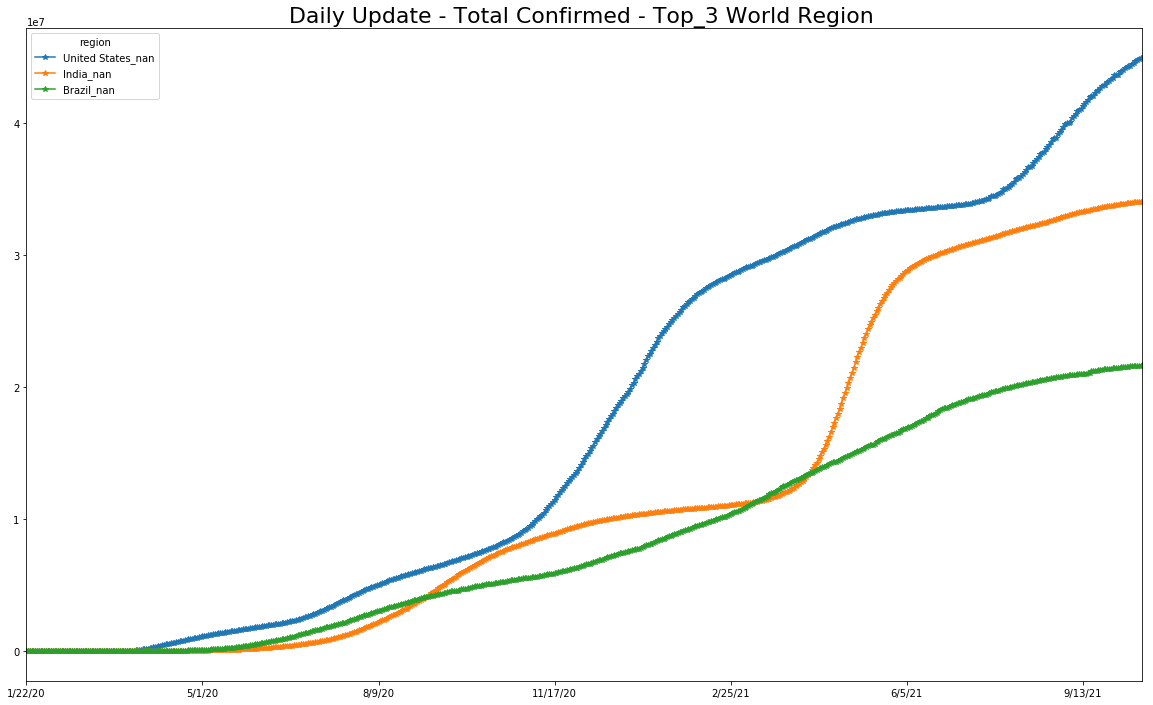

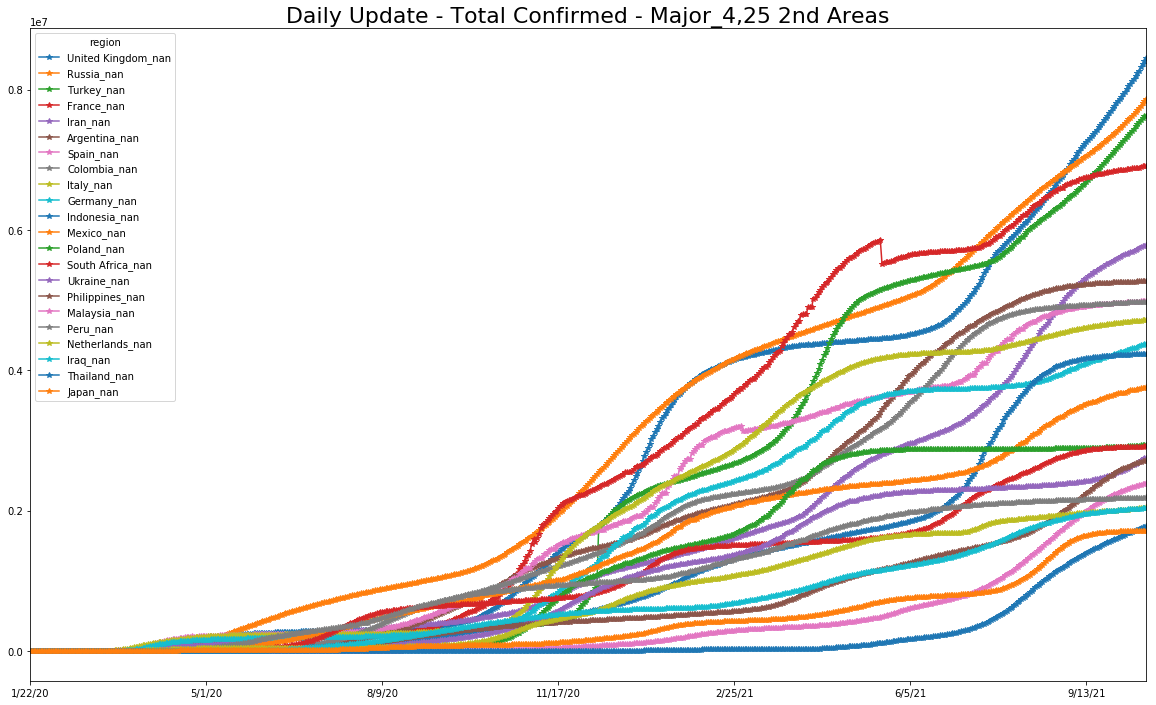

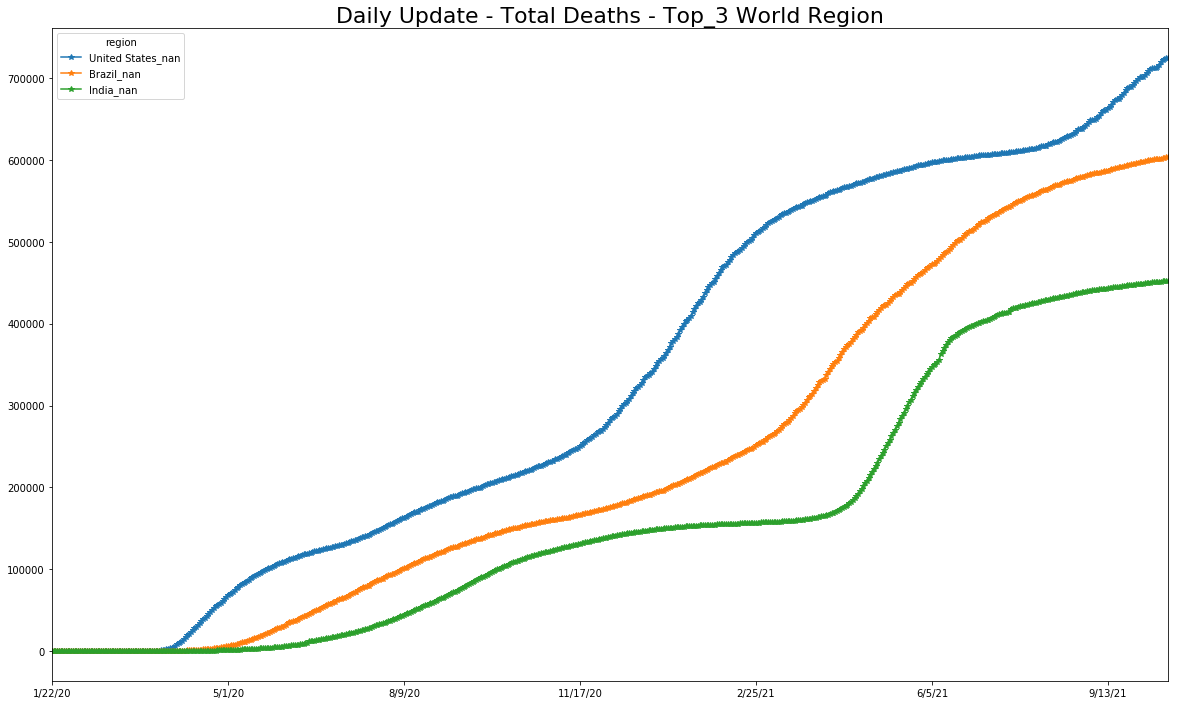

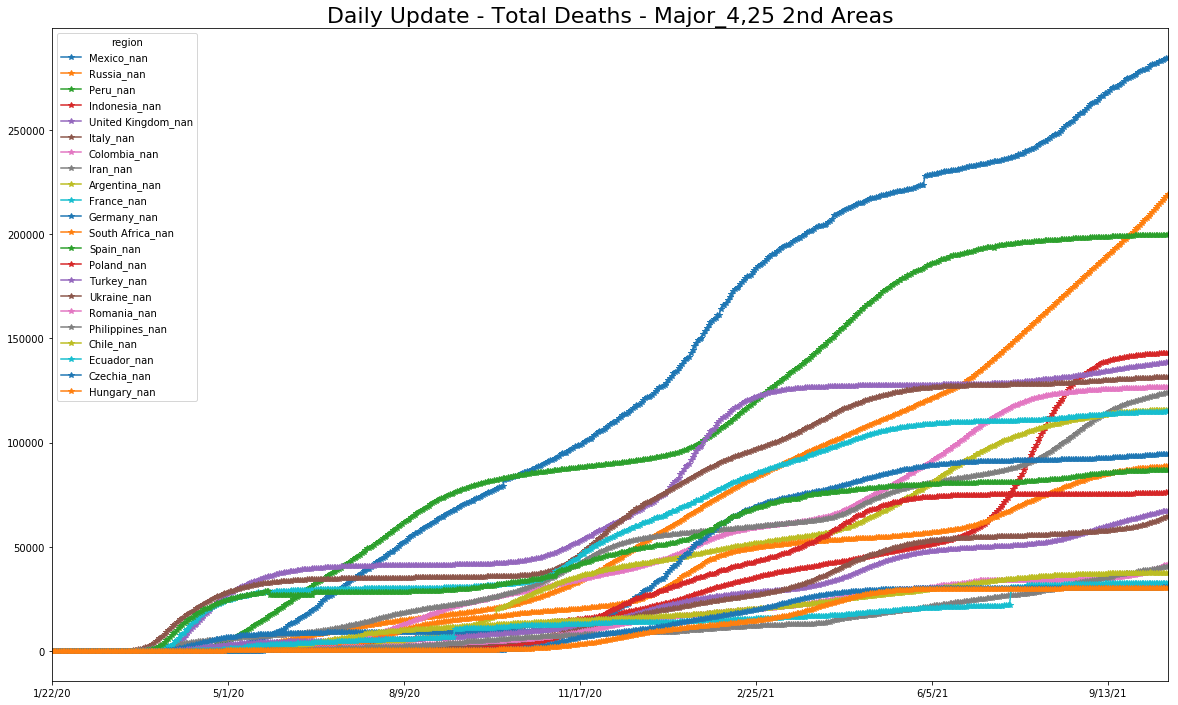

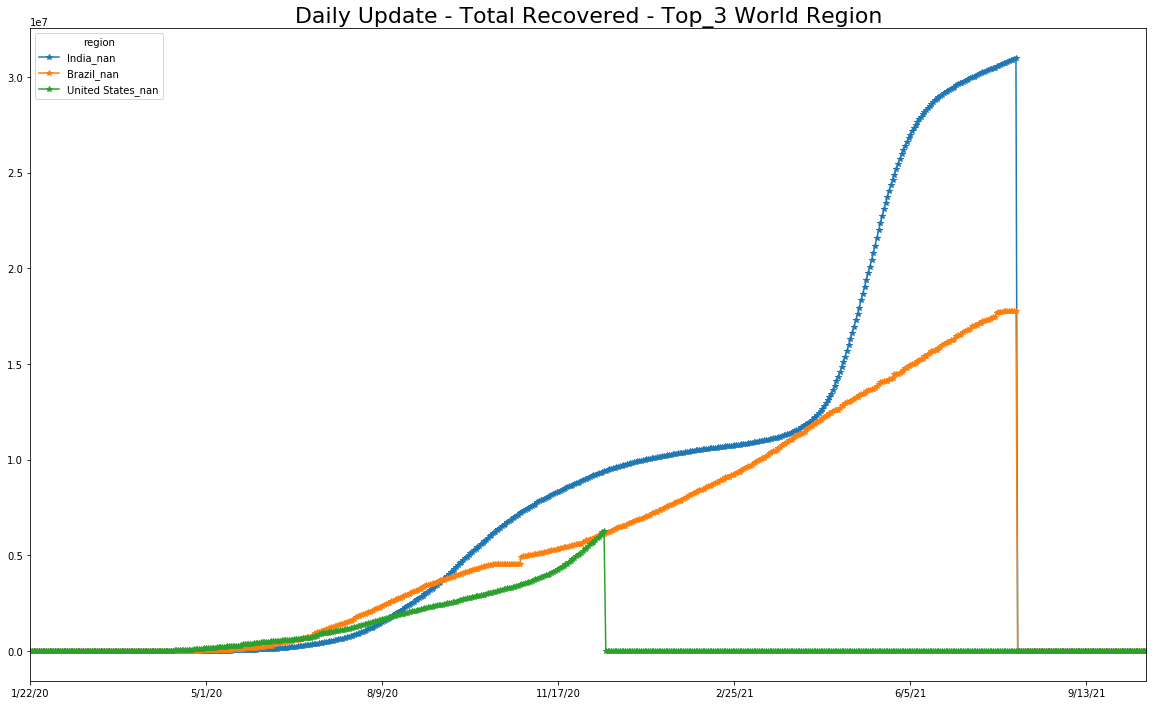

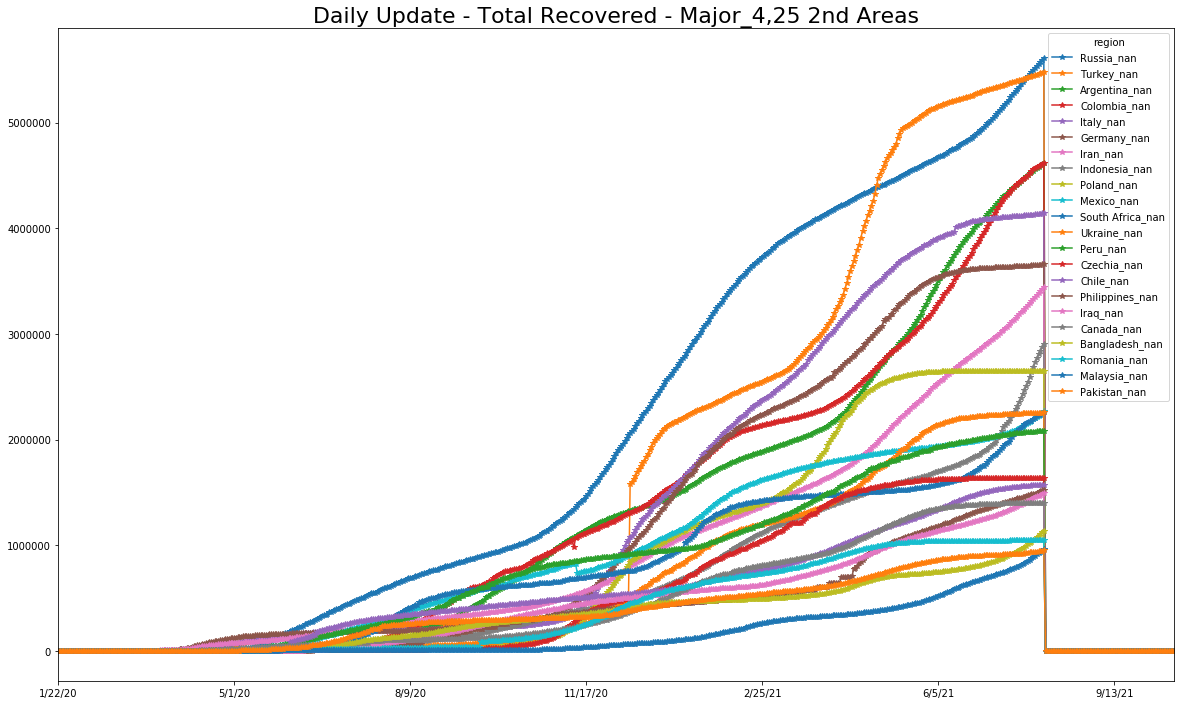

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2021/10/18


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
4/13/21            57364       128752       118799        12614       23697   
4/14/21            57492       128959       118975        12641       23841   
4/15/21            57534       129128       119142        12641       23951   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
4/13/21                     1201        2579000       204053   
4/14/21                     1201        2604157       205128   
4/15/21                     1209        2629156       206142   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
4/13/21                                     123                       5347   
4/14/21                                     123                       5356   
4/15/21                                     123                       5363   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
4/13/21  ...           31400634       149430           85291            3   
4/14/21  ...           31476253       152089           85503            3   
4/15/21  ...           31550222       156499           85730            3   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
4/13/21         176972         2714                  272767       5507   
4/14/21         178094         2733                  274690       5582   
4/15/21         179365         2758                  276407       5657   

region   Zambia_nan  Zimbabwe_nan  
4/13/21       90218         37330  
4/14/21       90389         37369  
4/15/21       90532         37422  

[3 rows x 279 columns]

In [25]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
10/14/21           155682       176667       205005        15326       62385   
10/15/21           155688       177108       205106        15338       62606   
10/16/21           155739       177536       205199        15338       62789   
10/17/21           155764       177971       205286        15338       62842   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
10/14/21                     3830        5270003       276666   
10/15/21                     3858        5271361       278431   
10/16/21                     3888        5272151       280294   
10/17/21                     3888        5272551       281991   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
10/14/21                                    1518                      70781   
10/15/21                                    1538                      71099   
10/16/21                                    1571                      71399   
10/17/21                                    1588                      71658   

region    ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
10/14/21  ...           44767906       390575          179711            4   
10/15/21  ...           44884598       390762          180162            4   
10/16/21  ...           44916423       390915          180566            4   
10/17/21  ...           44933336       391044          180958            4   

region    Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
10/14/21         388743       853842                  446294       9467   
10/15/21         390045       857639                  447032       9495   
10/16/21         390045       860860                  447032       9512   
10/17/21         392762       864053                  447032       9526   

region    Zambia_nan  Zimbabwe_nan  
10/14/21      209431        132251  
10/15/21      209477        132285  
10/16/21      209505        132333  
10/17/21      209521        132368  

[4 rows x 279 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-04-14  Afghanistan_nan      57492             0             0   
2     2021-04-15  Afghanistan_nan      57534           128             0   
3     2021-04-16  Afghanistan_nan      57612            42             0   
4     2021-04-17  Afghanistan_nan      57721            78           248   
5     2021-04-18  Afghanistan_nan      57793           109           229   
6     2021-04-19  Afghanistan_nan      57898            72           259   
7     2021-04-20  Afghanistan_nan      58037           105           286   
8     2021-04-21  Afghanistan_nan      58214           139           316   
9     2021-04-22  Afghanistan_nan      58312           177           421   
10    2021-04-23  Afghanistan_nan      58542            98           414   
11    2021-04-24  Afghanistan_nan      58730           230           505   
12    2021-04-25  Afghanistan_nan      58843           188           516   
13    2021-04-26  Afghanistan_nan      59015           113           531   
14    2021-04-27  Afghanistan_nan      59225           172           473   
15    2021-04-28  Afghanistan_nan      59370           210           495   
16    2021-04-29  Afghanistan_nan      59576           145           527   
17    2021-04-30  Afghanistan_nan      59745           206           561   
18    2021-05-01  Afghanistan_nan      59939           169           520   
19    2021-05-02  Afghanistan_nan      60122           194           569   
20    2021-05-03  Afghanistan_nan      60300           183           546   
21    2021-05-04  Afghanistan_nan      60563           178           555   
22    2021-05-05  Afghanistan_nan      60797           263           624   
23    2021-05-06  Afghanistan_nan      61162           234           675   
24    2021-05-07  Afghanistan_nan      61455           365           862   
25    2021-05-08  Afghanistan_nan      61755           293           892   
26    2021-05-09  Afghanistan_nan      61842           300           958   
27    2021-05-10  Afghanistan_nan      62063            87           680   
28    2021-05-11  Afghanistan_nan      62403           221           608   
29    2021-05-12  Afghanistan_nan      62718           340           648   
30    2021-05-13  Afghanistan_nan      63045           315           876   
...          ...              ...        ...           ...           ...   
53835 2021-09-19     Zimbabwe_nan     127938           107           656   
53836 2021-09-20     Zimbabwe_nan     128186           199           570   
53837 2021-09-21     Zimbabwe_nan     128186           248           554   
53838 2021-09-22     Zimbabwe_nan     128804             0           447   
53839 2021-09-23     Zimbabwe_nan     129134           618           866   
53840 2021-09-24     Zimbabwe_nan     129134           330           948   
53841 2021-09-25     Zimbabwe_nan     129505             0           948   
53842 2021-09-26     Zimbabwe_nan     129625           371           701   
53843 2021-09-27     Zimbabwe_nan     129919           120           491   
53844 2021-09-28     Zimbabwe_nan     130272           294           785   
53845 2021-09-29     Zimbabwe_nan     130485           353           767   
53846 2021-09-30     Zimbabwe_nan     130820           213           860   
53847 2021-10-01     Zimbabwe_nan     131028           335           901   
53848 2021-10-02     Zimbabwe_nan     131094           208           756   
53849 2021-10-03     Zimbabwe_nan     131129            66           609   
53850 2021-10-04     Zimbabwe_nan     131129            35           309   
53851 2021-10-05     Zimbabwe_nan     131205             0           101   
53852 2021-10-06     Zimbabwe_nan     131434            76           111   
53853 2021-10-07     Zimbabwe_nan     131523           229           305   
53854 2021-10-08     Zimbabwe_nan     131705            89           394   
53855 2021-10-09     Zimbabwe_nan     131762           182  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
53864 2021-10-18  Zimbabwe_nan          0            35           117   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
53864           572         100.026456         100.088476         100.434012   

       last_day  kalman_prediction  population  infected_rate  min  max  
53864    132368           132487.0    14862924       0.000089  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
53864 2021-10-18  Zimbabwe_nan          0            35           117   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
53864           572         100.026456         100.088476         100.434012   

       last_day  kalman_prediction  population  infected_rate  min  max  
53864    132368           132487.0    14862924       0.000089  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
52728  2021-10-16  Zimbabwe_nan     132333            34           269   
52729  2021-10-17  Zimbabwe_nan     132368            48           225   
52730  2021-10-18  Zimbabwe_nan          0            35           117   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
52728           580         100.025716         100.203771         100.440386   
52729           571         100.036293         100.170323         100.433365   
52730           572         100.026456         100.088476         100.434012   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
52728               132285  ...    14862924       0.000089  NaN  NaN   
52729               132333  ...    14862924       0.000089  NaN  NaN   
52730               132368  ...    14862924       0.000089  NaN  NaN   

       population_percentage : infected_rate confirmed  \
52728                                         0.008900   
52729                                         0.008904   
52730                                         0.008906   

       population_percentage : factor 9/10 infected_rate confirmed  \
52728                                           0.080104             
52729                                           0.080133             
52730                                           0.080154             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
52728                   115.0                           7.737374   
52729                   121.0                           8.141063   
52730                   119.0                           8.006500   

       delta : roling 7day AVG  \
52728                82.857143   
52729                81.571429   
52730                81.714286   

       delta : aprox 14-day case notification rate per 100k hab  
52728                                           7.804655         
52729                                           7.683549         
52730                                           7.697005         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
269  United States_nan  1.093940e+13  3.307477e+06  308562.335106


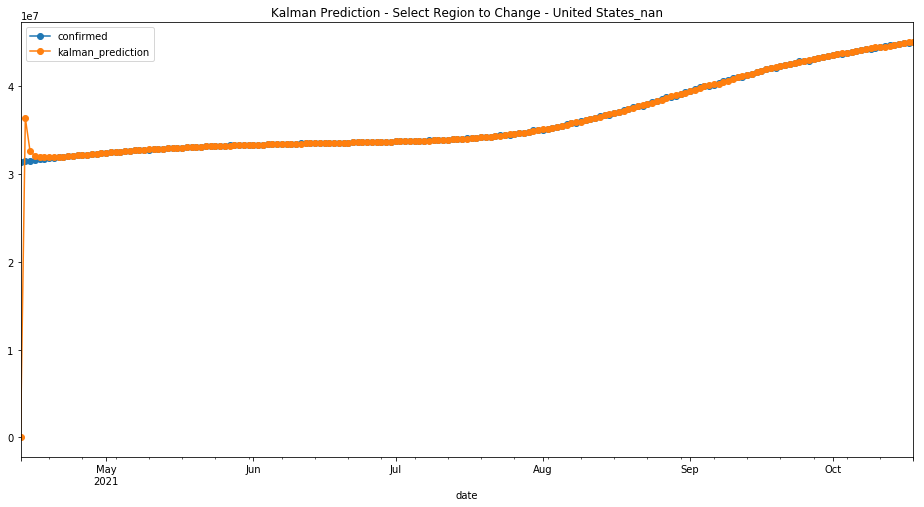

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
217  Russia_nan  3.347610e+11  578585.344585  49152.542553


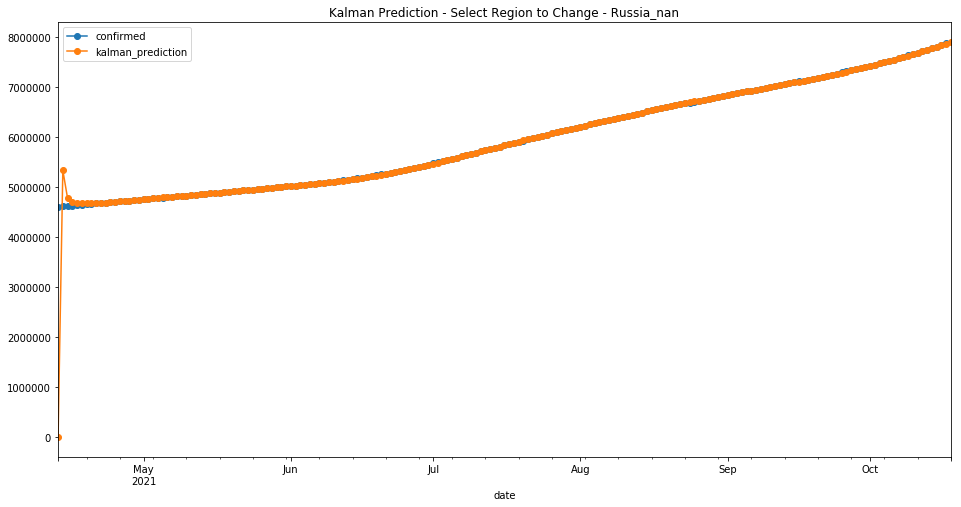

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
30  Brazil_nan  2.520152e+12  1.587499e+06  149895.175532


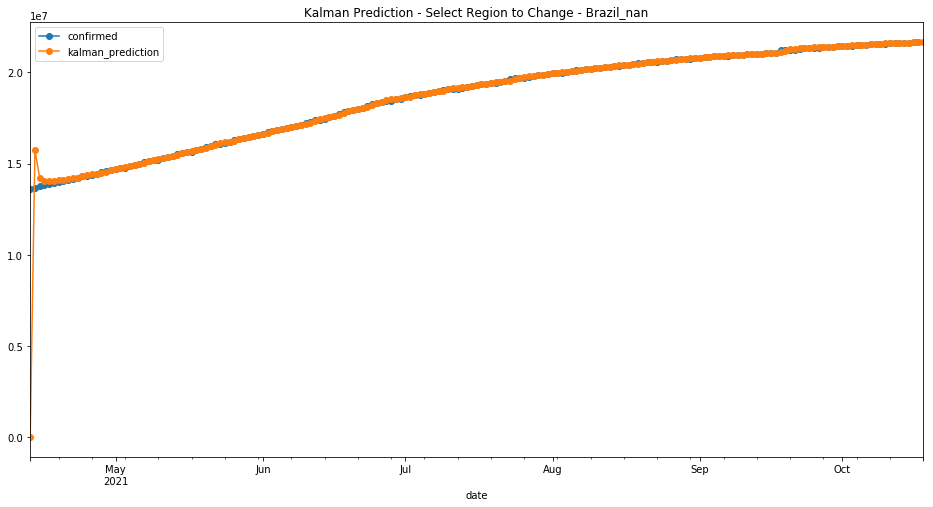

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse          mae
268  United Kingdom_nan  3.860442e+11  621324.512708  55130.31383


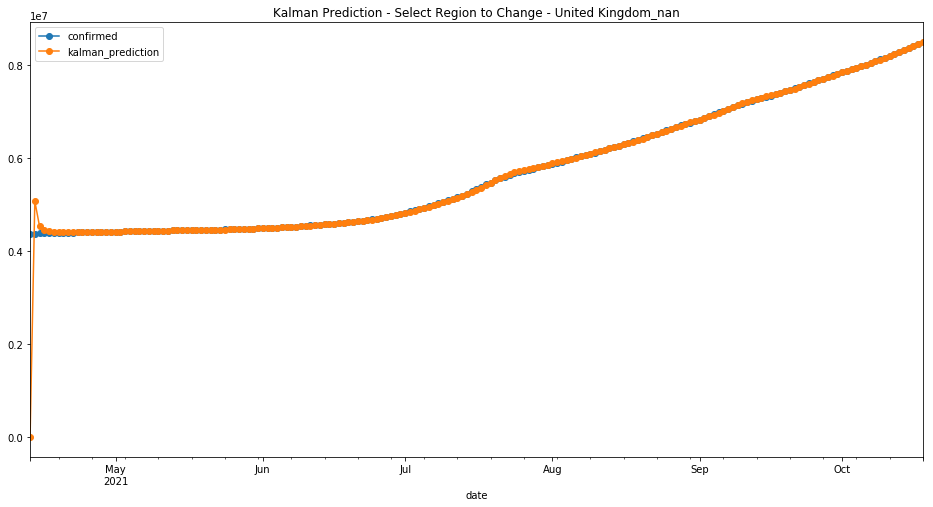

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp198d92sd
  JVM stdout: /tmp/tmp198d92sd/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp198d92sd/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    2 years, 11 months and 21 days !!!
H2O cluster name:           H2O_from_python_unknownUser_kphgwc
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2021-10-10
last_train_date= 2021-10-17
first_bootstrap_date= 2021-10-09
boost_bootstrap_date= 2021-10-14
first_test_date= 2021-10-08
last_test_date= 2021-10-18
first_valid_date= 2021-10-16


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   156897.0     155466 2021-10-09  Afghanistan_nan
1   156920.0     155508 2021-10-10  Afghanistan_nan
2   156942.0     155540 2021-10-11  Afghanistan_nan
3   156978.0     155599 2021-10-12  Afghanistan_nan
4   157014.0     155627 2021-10-13  Afghanistan_nan
5   157065.0     155682 2021-10-14  Afghanistan_nan
6   157102.0     155688 2021-10-15  Afghanistan_nan
7   157146.0     155739 2021-10-16  Afghanistan_nan
8   157164.0     155764 2021-10-17  Afghanistan_nan
9   157205.0          0 2021-10-18  Afghanistan_nan
10  175172.0     174643 2021-10-09      Albania_nan
11  175633.0     174968 2021-10-10      Albania_nan
12  176061.0     175163 2021-10-11      Albania_nan
13  176343.0     175664 2021-10-12      Albania_nan
14  176567.0     176172 2021-10-13      Albania_nan
15  177007.0     176667 2021-10-14      Albania_nan
16  177500.0     177108 2021-10-15      Albania_nan
17  177987.0     177536 2021-10-16      Albania_nan
18  178440.0     177971 2021-10-17      Albania_nan
19  178882.0          0 2021-10-18      Albania_nan
20  205881.0     204490 2021-10-09      Algeria_nan
21  205980.0     204597 2021-10-10      Algeria_nan
22  206076.0     204695 2021-10-11      Algeria_nan
23  206172.0     204790 2021-10-12      Algeria_nan
24  206263.0     204900 2021-10-13      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  496759.0     496780 2021-10-14  Azerbaijan_nan
176  498206.0     498630 2021-10-15  Azerbaijan_nan
177  499957.0     498630 2021-10-16  Azerbaijan_nan
178  500858.0     502207 2021-10-17  Azerbaijan_nan
179  503069.0          0 2021-10-18  Azerbaijan_nan
180   22256.0      21580 2021-10-09     Bahamas_nan
181   22503.0      21580 2021-10-10     Bahamas_nan
182   22491.0      21580 2021-10-11     Bahamas_nan
183   22455.0      21580 2021-10-12     Bahamas_nan
184   22436.0      21580 2021-10-13     Bahamas_nan
185   22409.0      21580 2021-10-14     Bahamas_nan
186   22389.0      21580 2021-10-15     Bahamas_nan
187   22374.0      21580 2021-10-16     Bahamas_nan
188   22366.0      21580 2021-10-17     Bahamas_nan
189   22361.0          0 2021-10-18     Bahamas_nan
190  274547.0     275597 2021-10-09     Bahrain_nan
191  274619.0     275654 2021-10-10     Bahrain_nan
192  274681.0     275734 2021-10-11     Bahrain_nan
193  274749.0     275803 2021-10-12     Bahrain_nan
194  274825.0     275862 2021-10-13     Bahrain_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date       region
220   556080.0     555793 2021-10-09  Belarus_nan
221   558082.0     557772 2021-10-10  Belarus_nan
222   560079.0     559715 2021-10-11  Belarus_nan
223   562046.0     561753 2021-10-12  Belarus_nan
224   564049.0     563813 2021-10-13  Belarus_nan
225   566096.0     565865 2021-10-14  Belarus_nan
226   568161.0     567938 2021-10-15  Belarus_nan
227   570242.0     570006 2021-10-16  Belarus_nan
228   572328.0     571987 2021-10-17  Belarus_nan
229   574363.0          0 2021-10-18  Belarus_nan
230  1262627.0    1261102 2021-10-09  Belgium_nan
231  1263604.0    1261102 2021-10-10  Belgium_nan
232  1263697.0    1266562 2021-10-11  Belgium_nan
233  1267001.0    1269002 2021-10-12  Belgium_nan
234  1270002.0    1272669 2021-10-13  Belgium_nan
235  1273715.0    1276221 2021-10-14  Belgium_nan
236  1277579.0    1279869 2021-10-15  Belgium_nan
237  1281643.0    1279869 2021-10-16  Belgium_nan
238  1283232.0    1279869 2021-10-17  Belgium_nan
239  1283514.0          0 2021-10-18  Belgium_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  107676024919.86317
# MSE on the validation data =  35586291150916.87
# R^2 on the training data =  0.9982737429835669
# R^2 on the validation data =  0.4311648559929585


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1634535097451_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 107676024919.86317
RMSE: 328140.2519043697
MAE: 17916.426432509565
RMSLE: 0.5937309214519801
Mean Residual Deviance: 107676024919.86317

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 35586291150916.87
RMSE: 5965424.641290582
MAE: 1612757.862174118
RMSLE: 7.982537904029276
Mean Residual Deviance: 35586291150916.87
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse    validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  -----------------  ------------------  ---------------------
     2021-10-18 05:31:44  0.060 sec   0.0                nan                 nan                 nan                  nan                nan                 nan
     2021-10-18 05:31:44  0.361 sec   1.0                224332.6049732538   40773.18312405081   50325117654.08594    5949508.401522783  1563979.1392877253  35396650219790.17
     2021-10-18 05:31:44  0.507 sec   2.0                348727.84500678716  43487.29132660016   121611109883.07777   5971691.90686007   1582422.9538640203  35661104230458.06
     2021-10-18 05:31:44  0.590 sec   3.0                551366.9600311416   45041.99841835171   304005524613.9826    5989882.061407888  1590236.522445358   35878687109576.016
     2021-10-18 05:31:44  0.715 sec   4.0                582030.1702475253   47804.36145372316   338759119078.36334   5996917.2317068    1592258.9124386075  35963016283941.945
---  ---                  ---         ---                ---                 ---                 ---                  ---                ---                 ---
     2021-10-18 05:31:48  4.077 sec   86.0               350710.96294711     22018.723922202684  122998179531.28918   5913518.521404113  1595631.203750503   34969701302989.49
     2021-10-18 05:31:52  8.102 sec   193.0              330474.61854032223  19016.02491569242   109213473499.3715    5945186.864453759  1609323.9077168468  35345246853273.52
     2021-10-18 05:31:56  12.129 sec  334.0              330479.1838447055   18320.974677324757  109216490954.66267   5957675.066331091  1612021.3494321473  35493892195983.17
     2021-10-18 05:32:00  16.142 sec  474.0              330810.0283412939   18037.752934755903  109435274851.16768   5967681.626189076  1612744.9104539703  35613223991554.695
     2021-10-18 05:32:01  17.023 sec  500.0              328140.2519043697   17916.426432509565  107676024919.86317   5965424.641290582  1612757.862174118   35586291150916.87


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  6.44246e+19            1                    0.310605
region             5.60099e+19            0.869386             0.270035
last_day           4.76628e+19            0.739822             0.229792
7_day_change       1.79268e+19            0.278259             0.0864287
3_day_change       9.58662e+18            0.148804             0.0462191
1_day_change       6.903e+18              0.107148             0.0332808
infected_rate      2.83277e+18            0.0439703            0.0136574
7_day_change_rate  9.86321e+17            0.0153097            0.00475526
3_day_change_rate  6.5141e+17             0.0101112            0.00314059
1_day_change_rate  4.3264e+17             0.00671544           0.00208585

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         6.442464e+19           1.000000    0.310605
1             region         5.600991e+19           0.869386    0.270035
2           last_day         4.766276e+19           0.739822    0.229792
3       7_day_change         1.792676e+19           0.278259    0.086429
4       3_day_change         9.586617e+18           0.148804    0.046219
5       1_day_change         6.903001e+18           0.107148    0.033281
6      infected_rate         2.832769e+18           0.043970    0.013657
7  7_day_change_rate         9.863205e+17           0.015310    0.004755
8  3_day_change_rate         6.514104e+17           0.010111    0.003141
9  1_day_change_rate         4.326401e+17           0.006715    0.002086

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


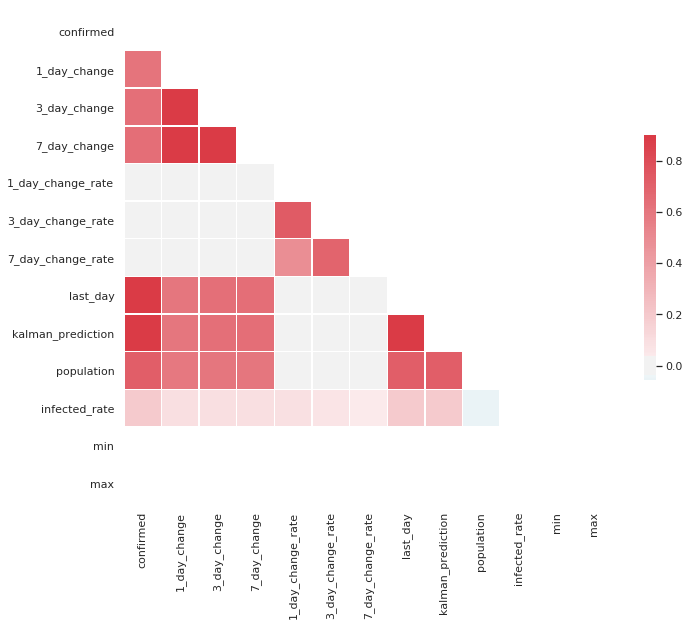

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.612945
3_day_change         0.632688
7_day_change         0.640205
1_day_change_rate    0.016070
3_day_change_rate    0.010002
7_day_change_rate    0.003369
last_day             0.992972
kalman_prediction    0.994458
population           0.719652
infected_rate        0.191645
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


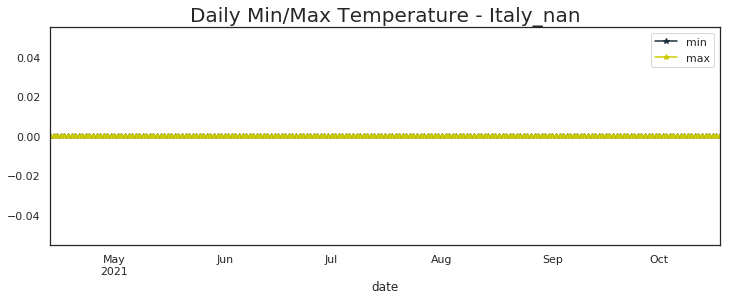

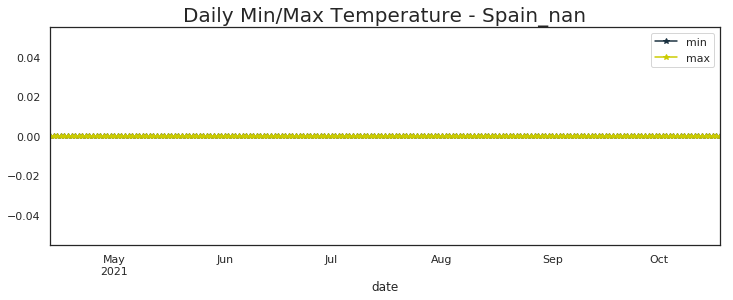

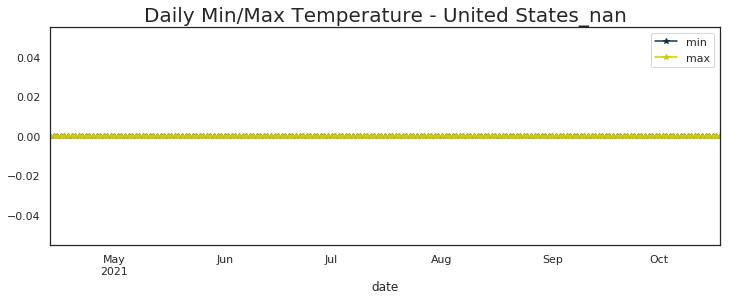

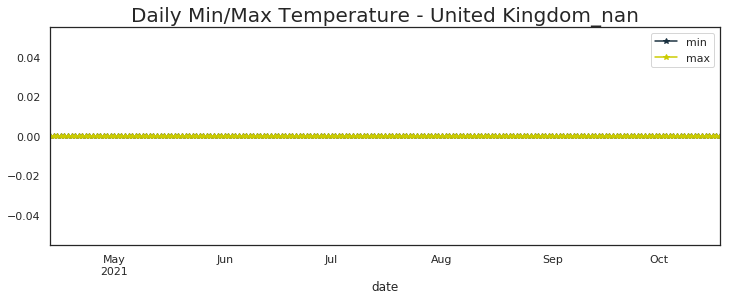

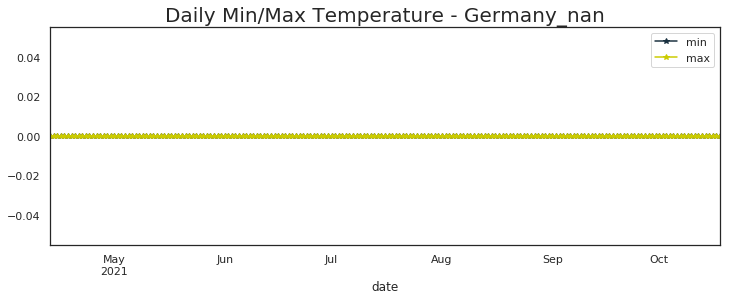

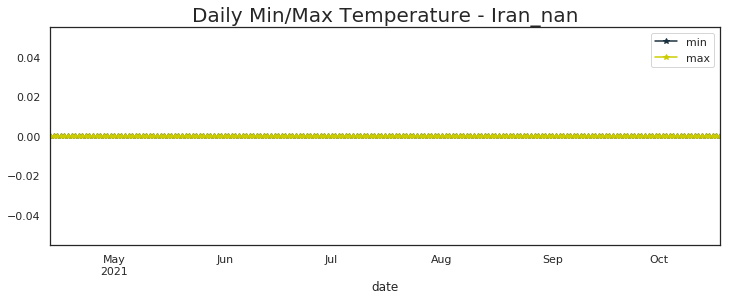

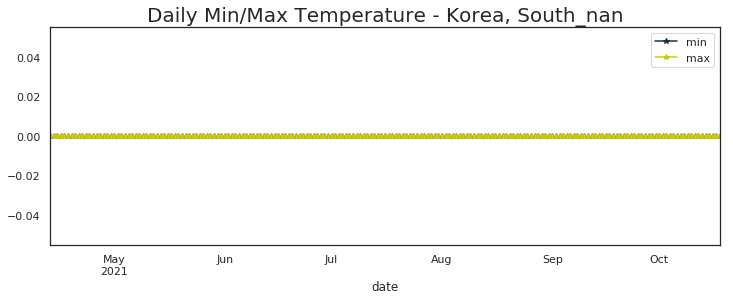

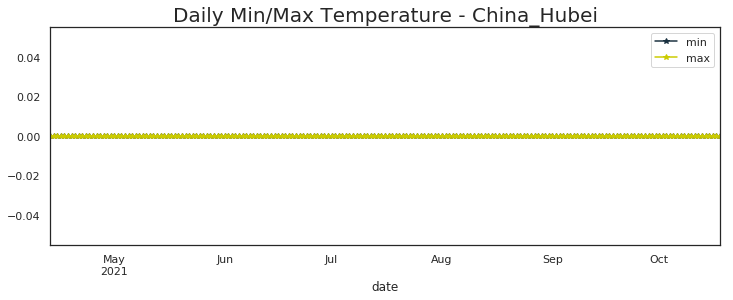

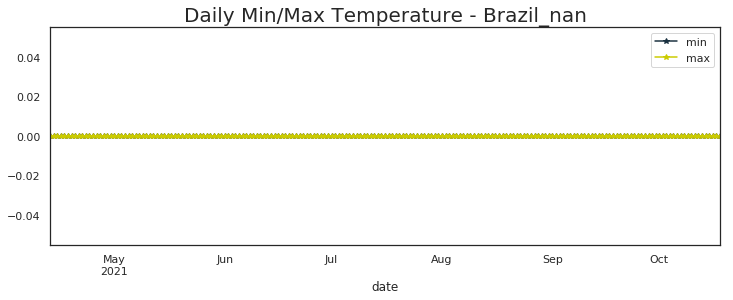

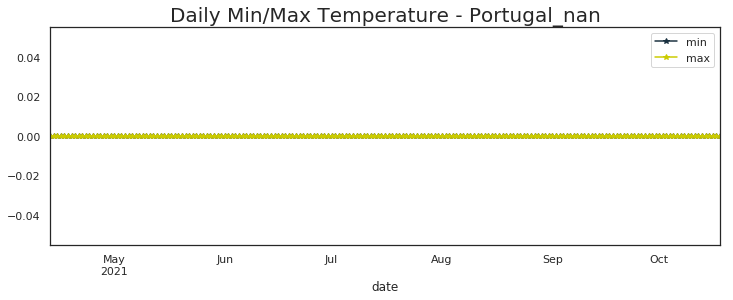

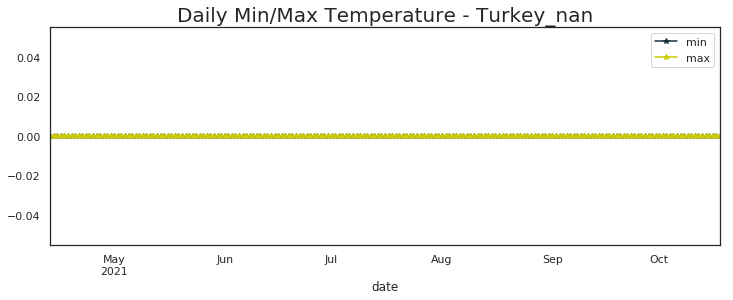

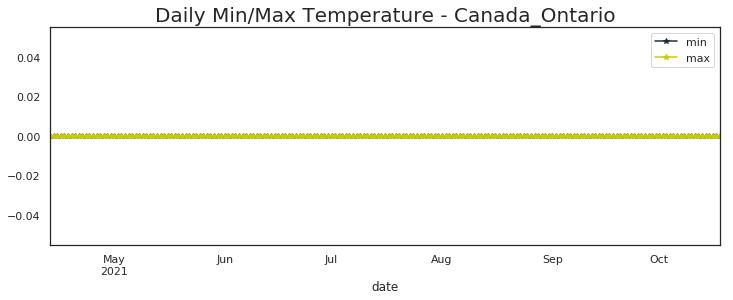

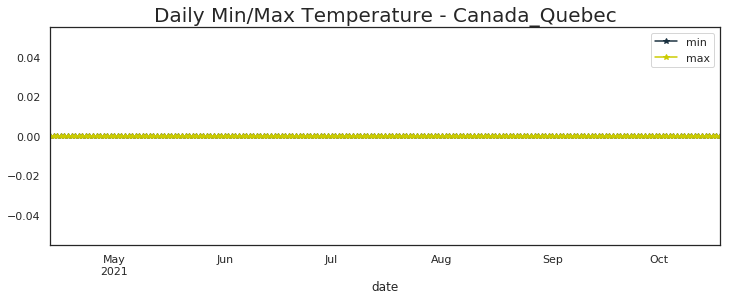

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
Russia_nan                  0.0  0.0
Turkey_nan                  0.0  0.0
France_nan                  0.0  0.0
Iran_nan                    0.0  0.0
Argentina_nan               0.0  0.0
Spain_nan                   0.0  0.0
Colombia_nan                0.0  0.0
Italy_nan                   0.0  0.0
Germany_nan                 0.0  0.0
Indonesia_nan               0.0  0.0
Mexico_nan                  0.0  0.0
Poland_nan                  0.0  0.0
South Africa_nan            0.0  0.0
Ukraine_nan                 0.0  0.0
Philippines_nan             0.0  0.0
Malaysia_nan                0.0  0.0
Peru_nan                    0.0  0.0
Netherlands_nan             0.0  0.0
Iraq_nan                    0.0  0.0
Thailand_nan                0.0  0.0
Ja

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

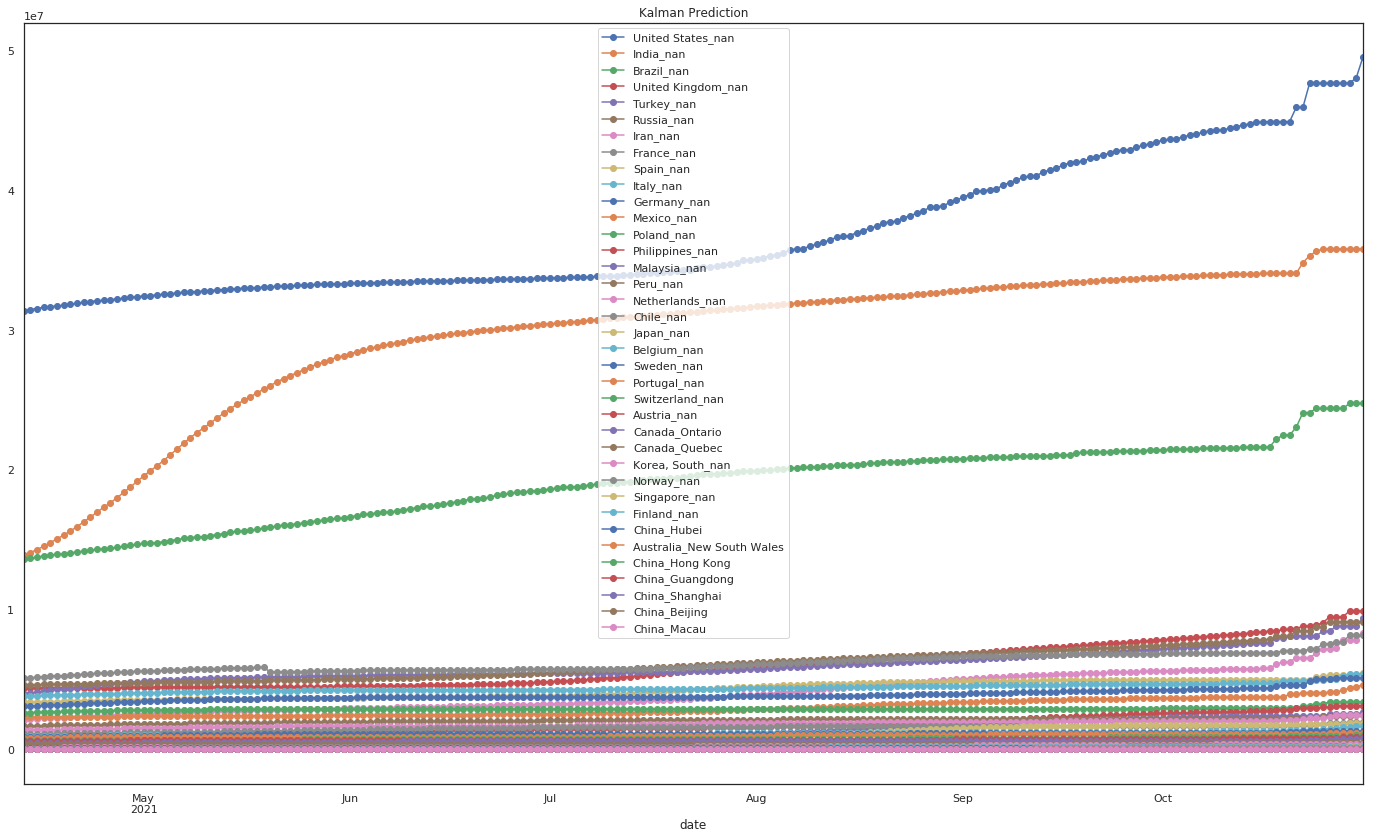

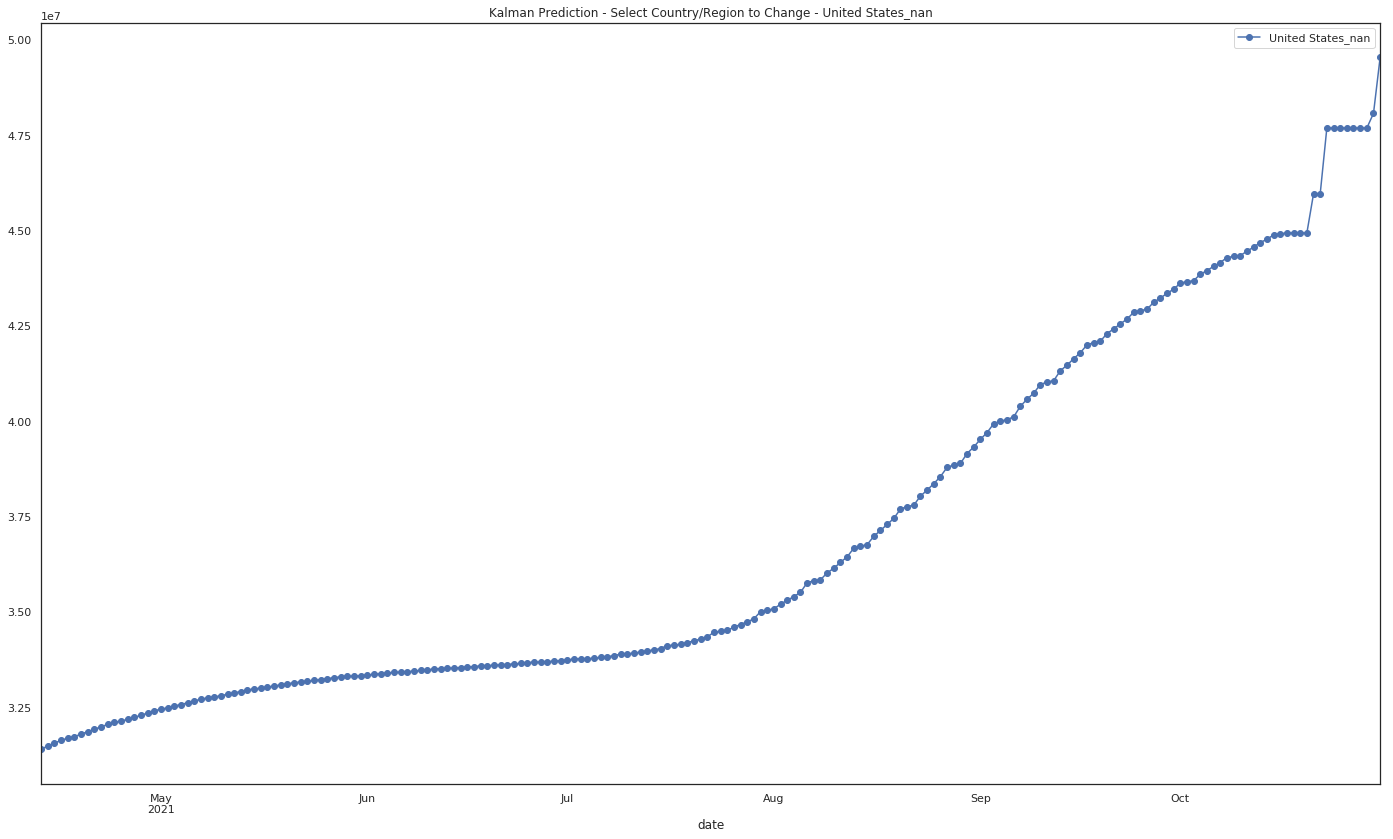

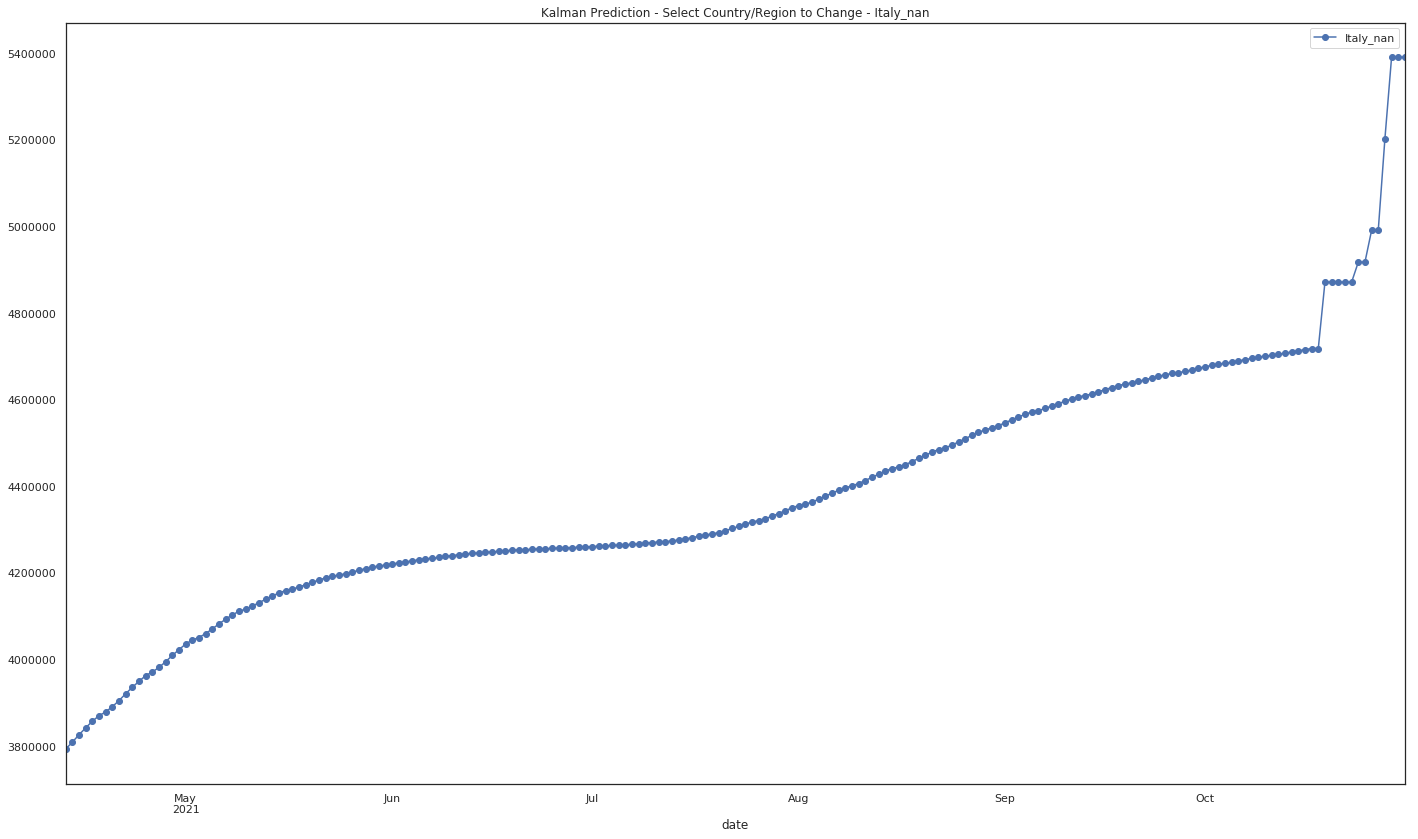

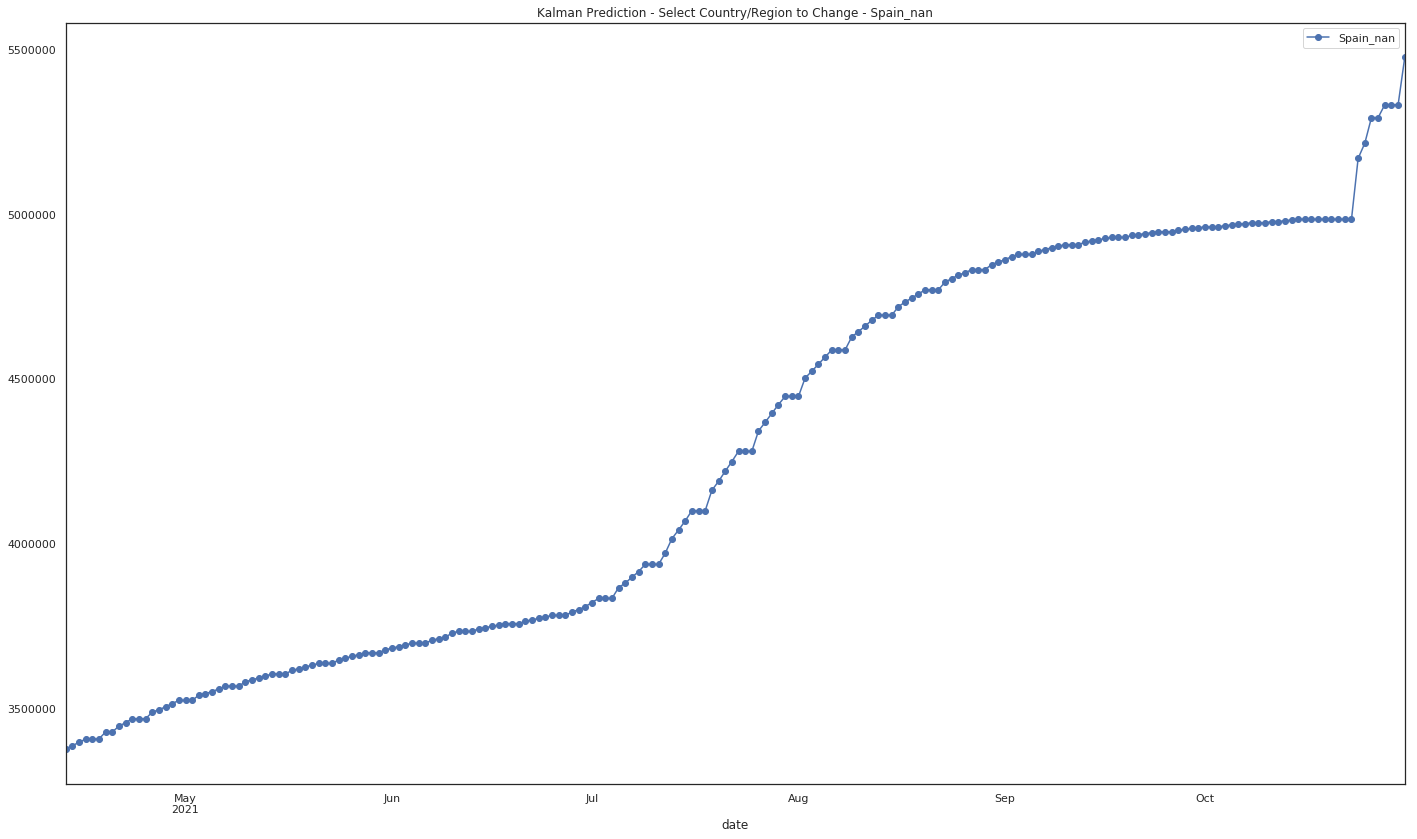

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


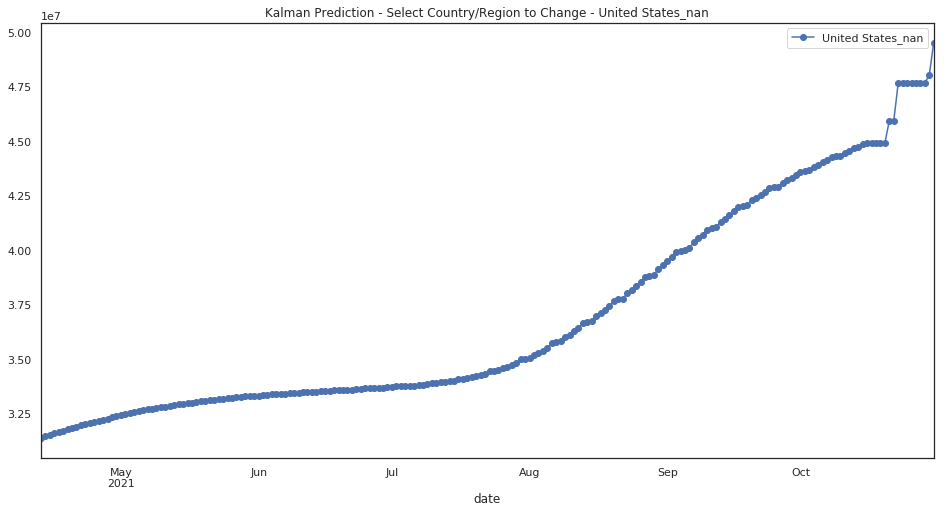

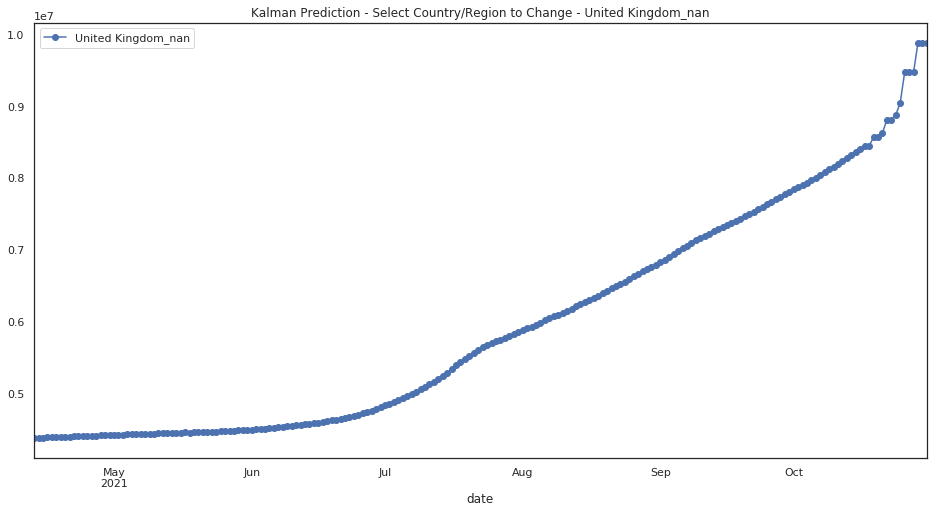

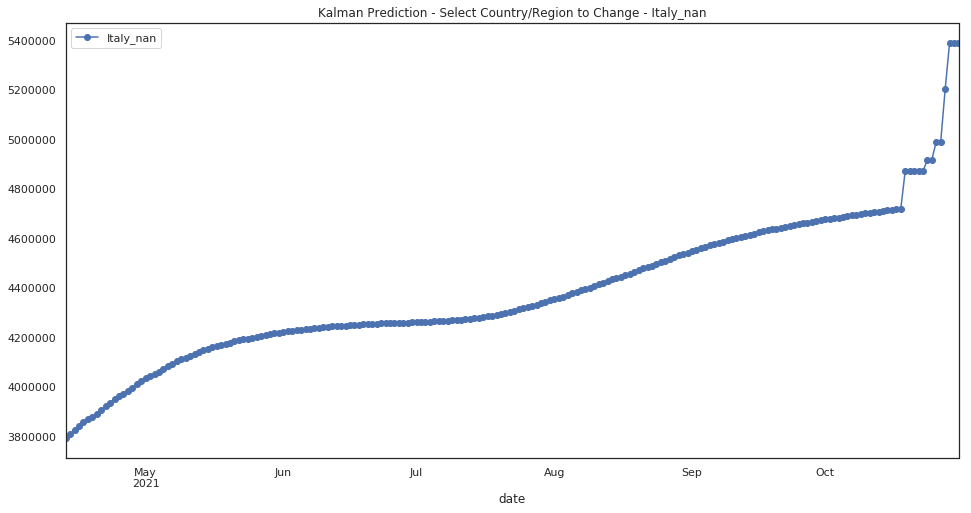

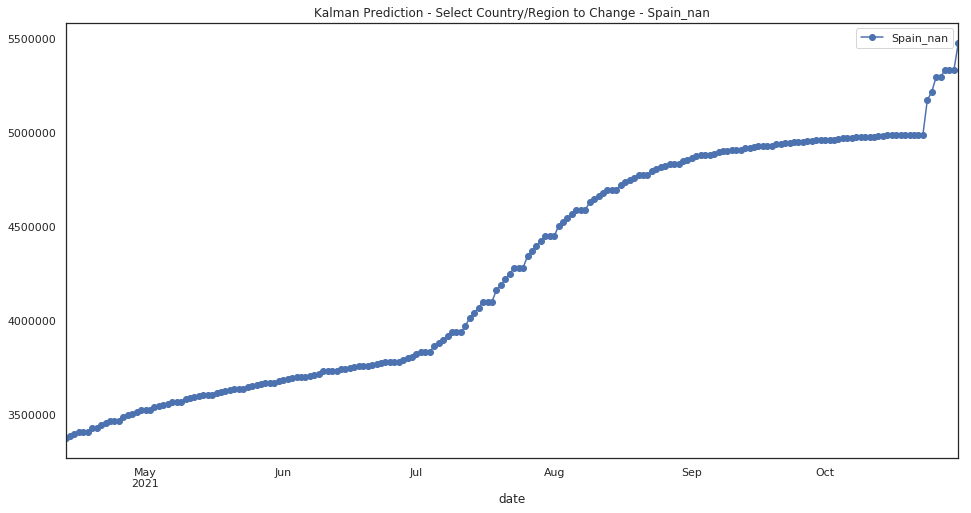

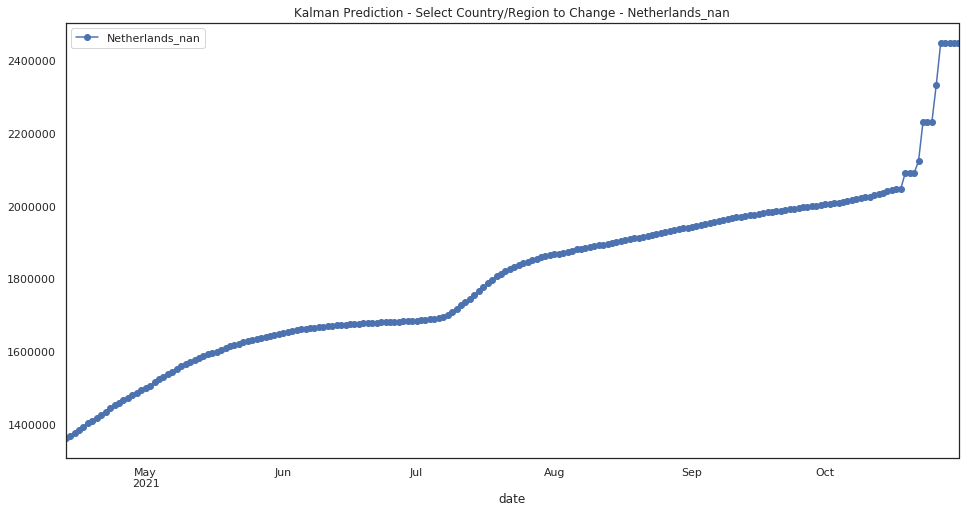

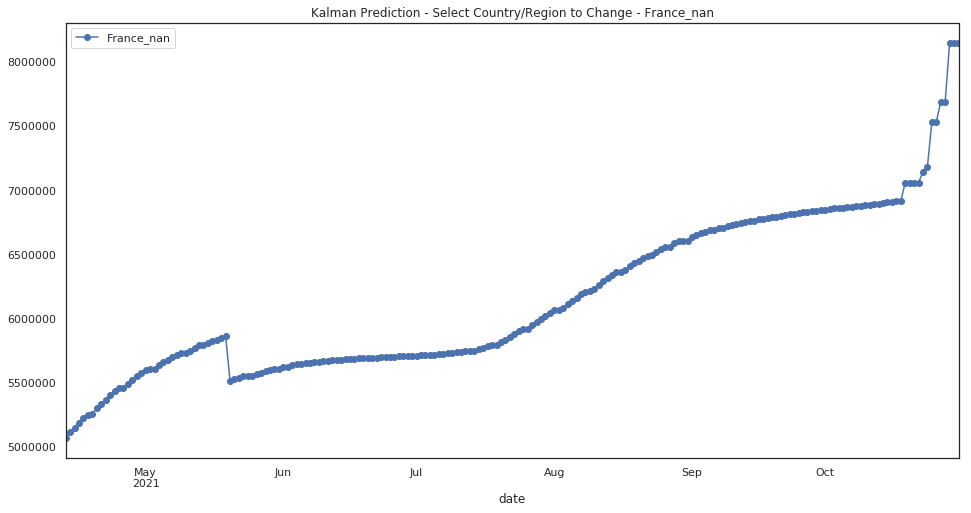

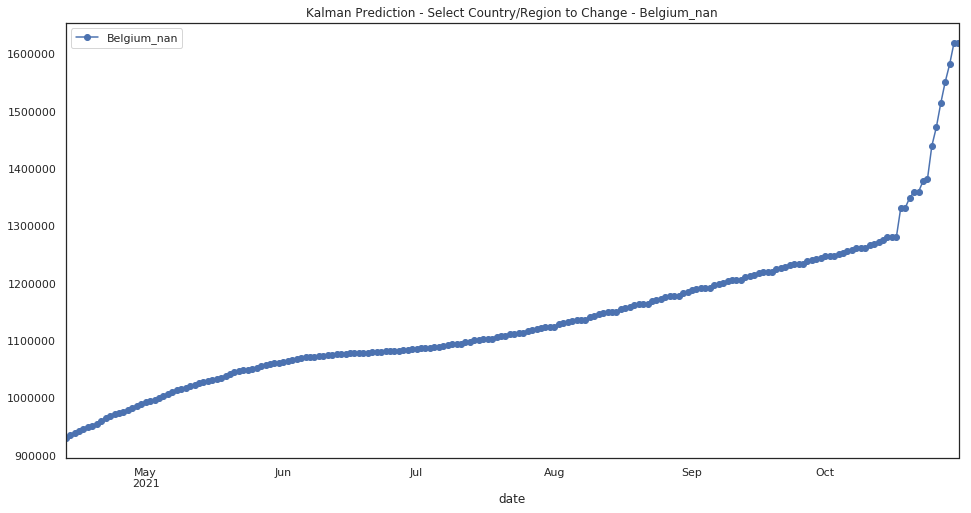

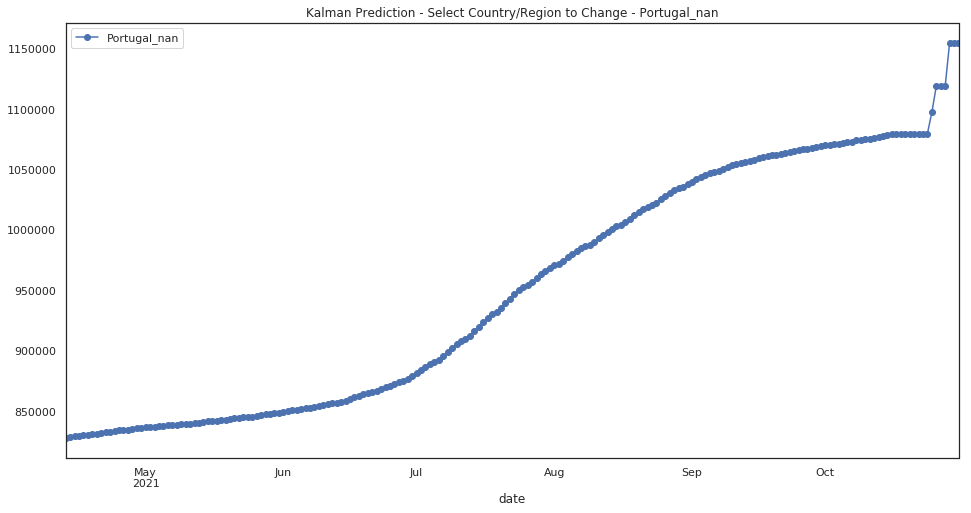

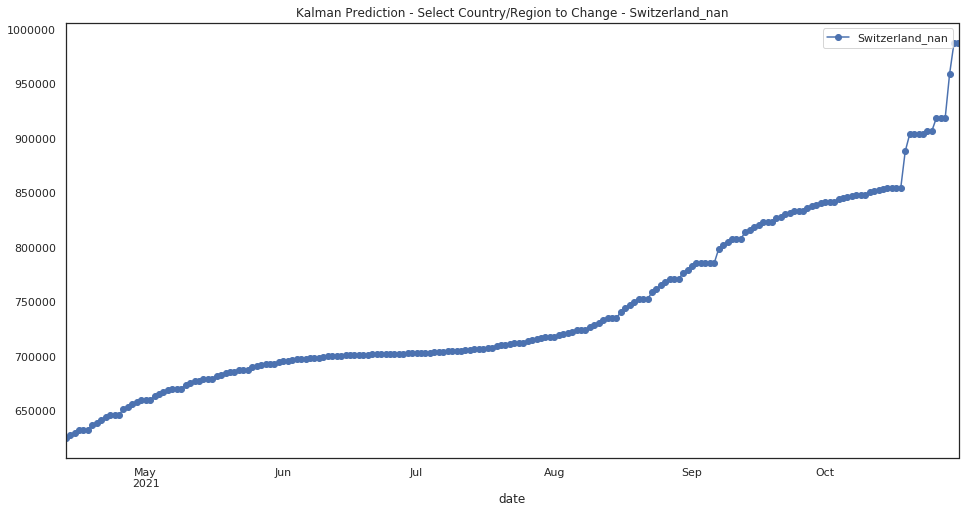

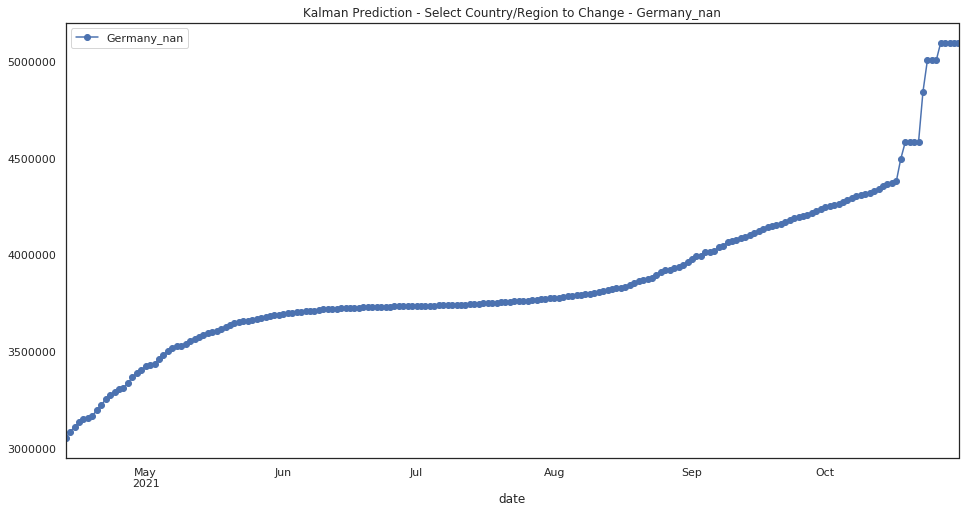

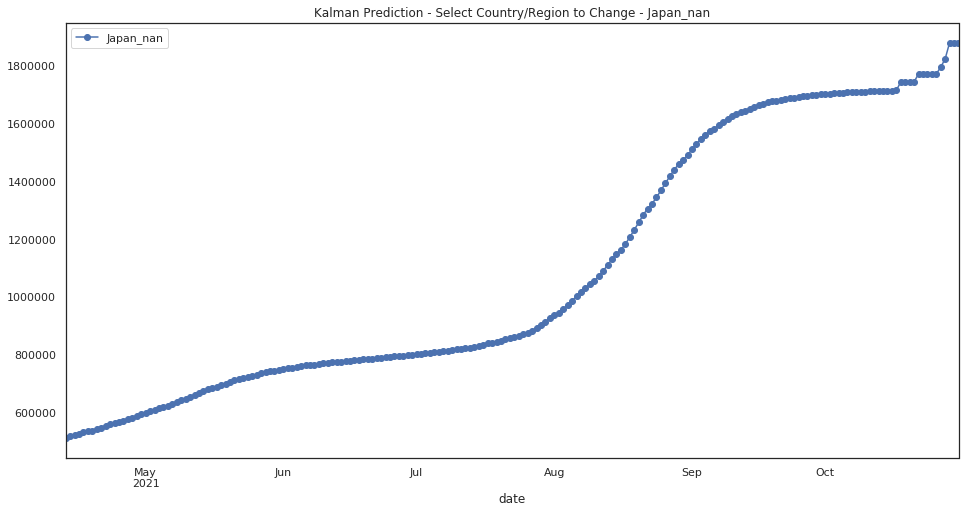

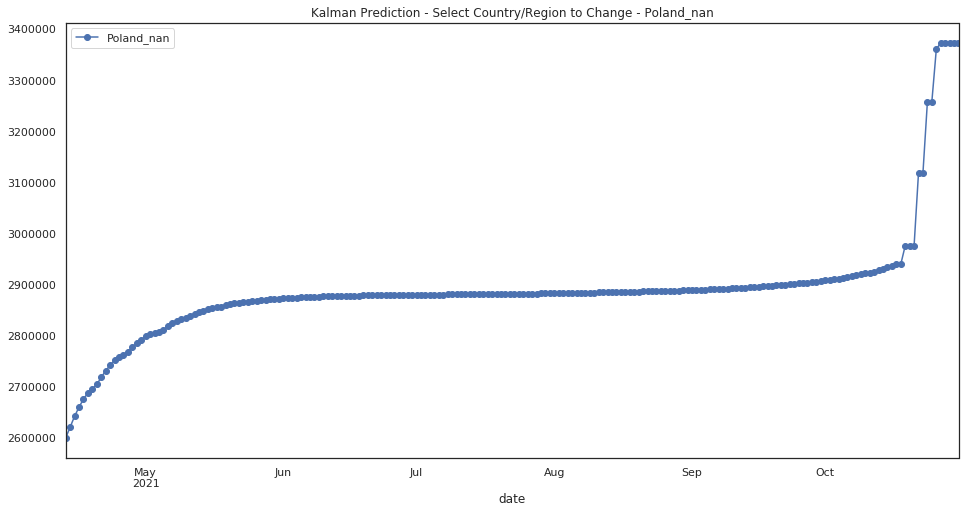

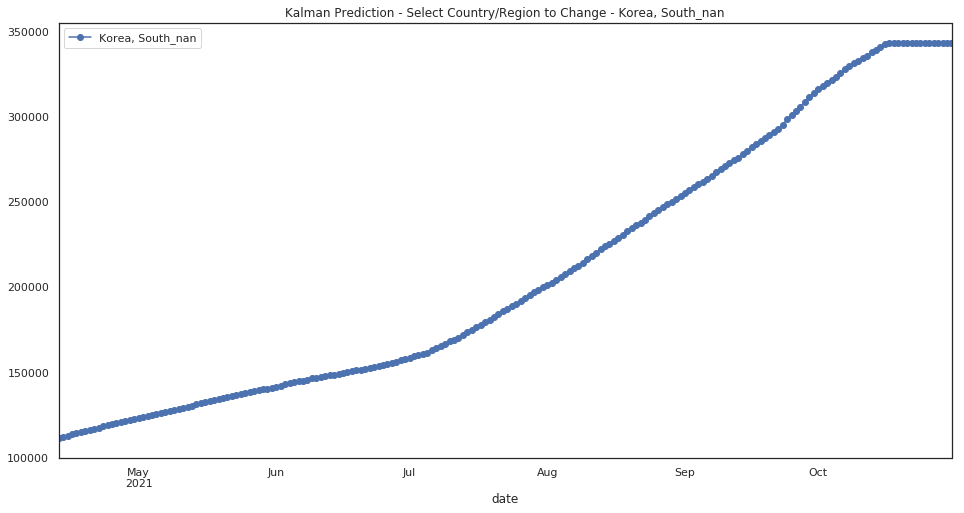

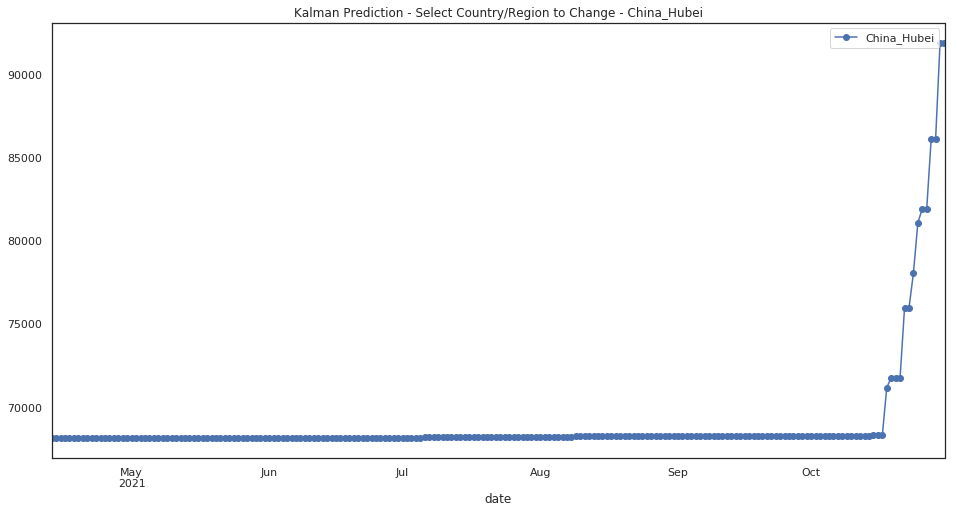

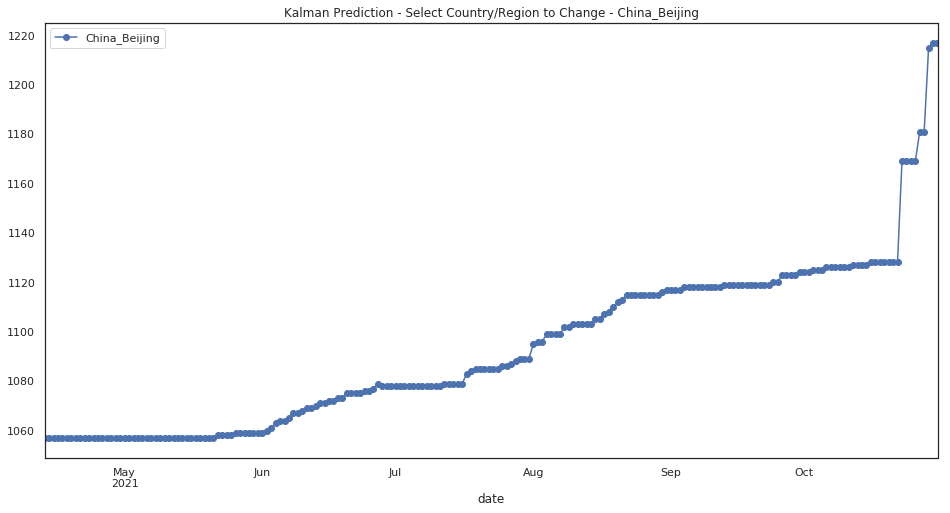

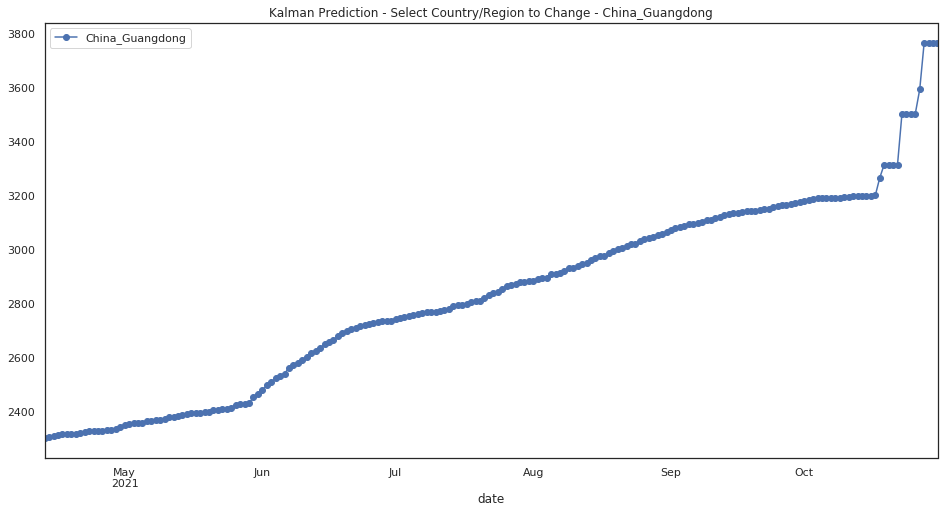

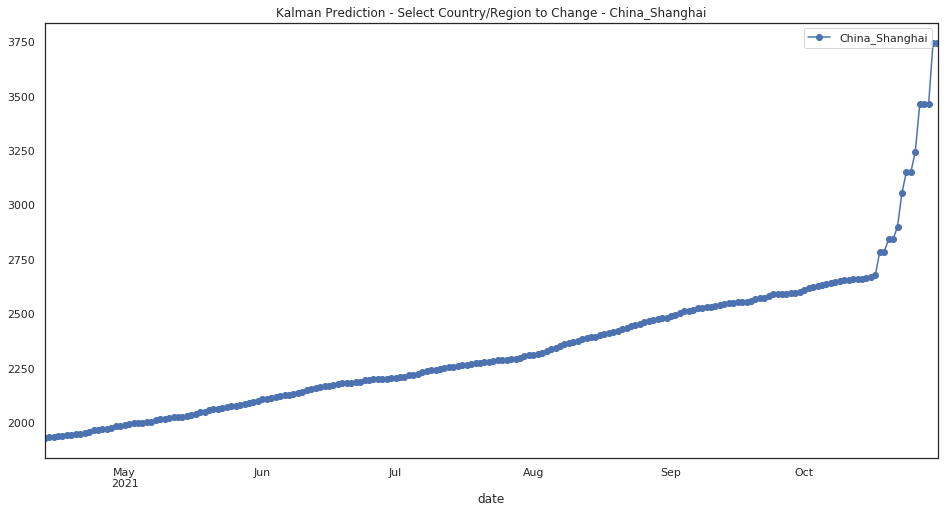

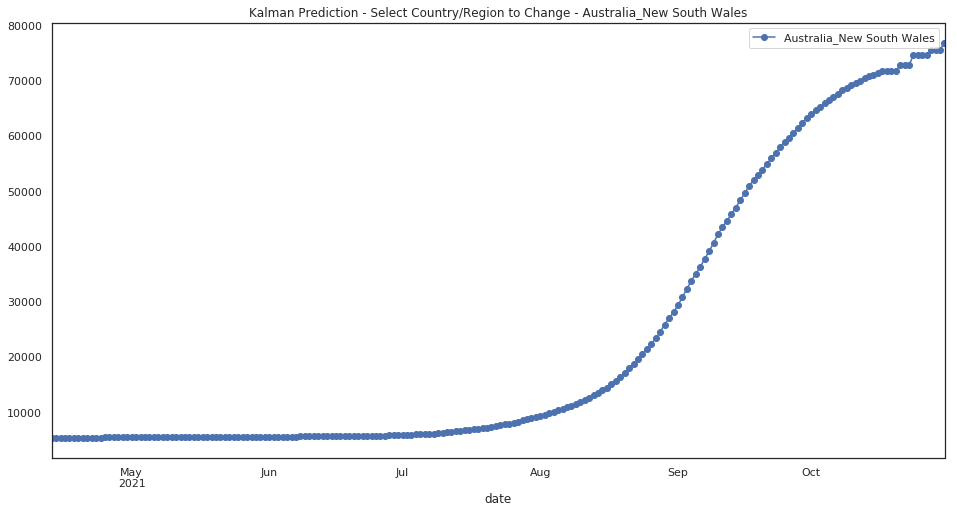

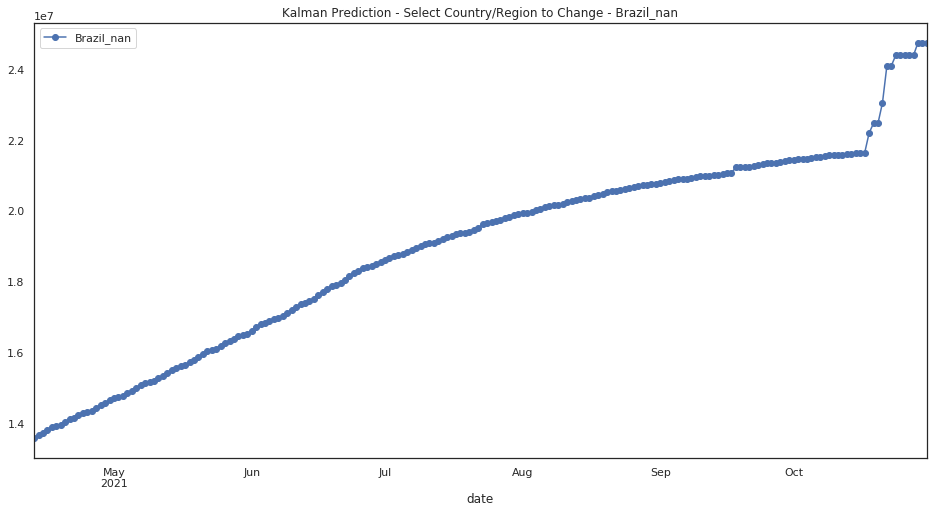

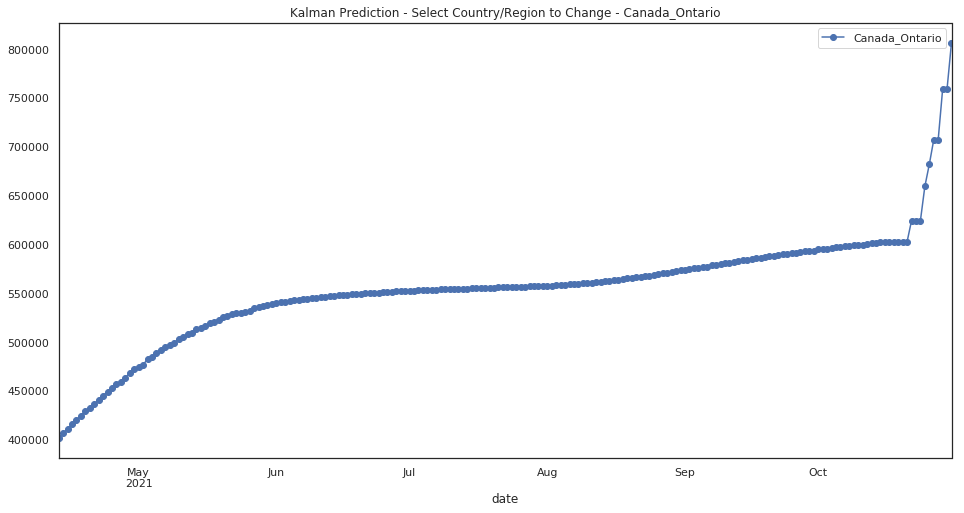

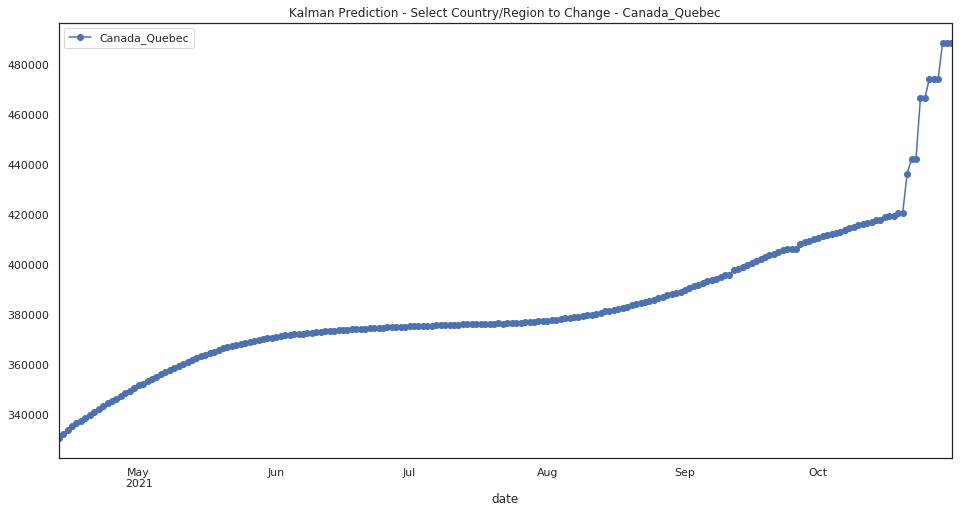

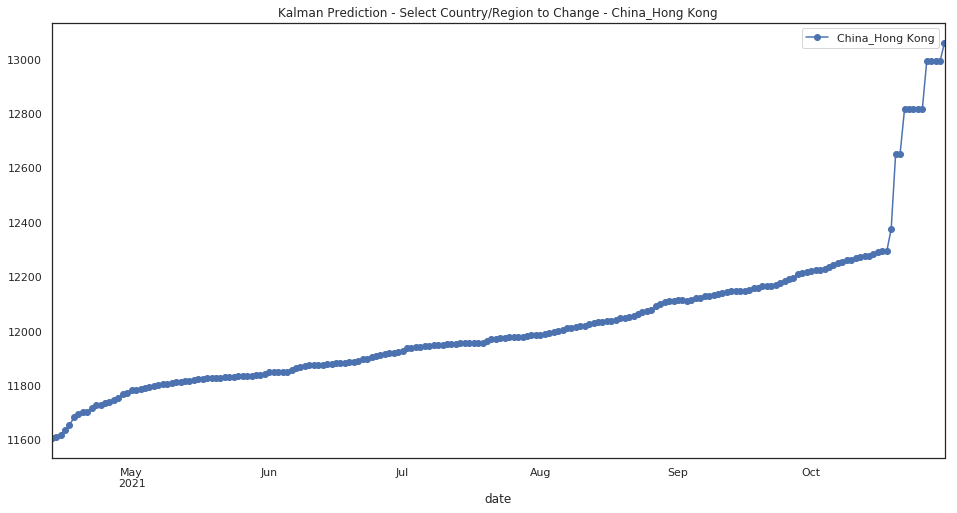

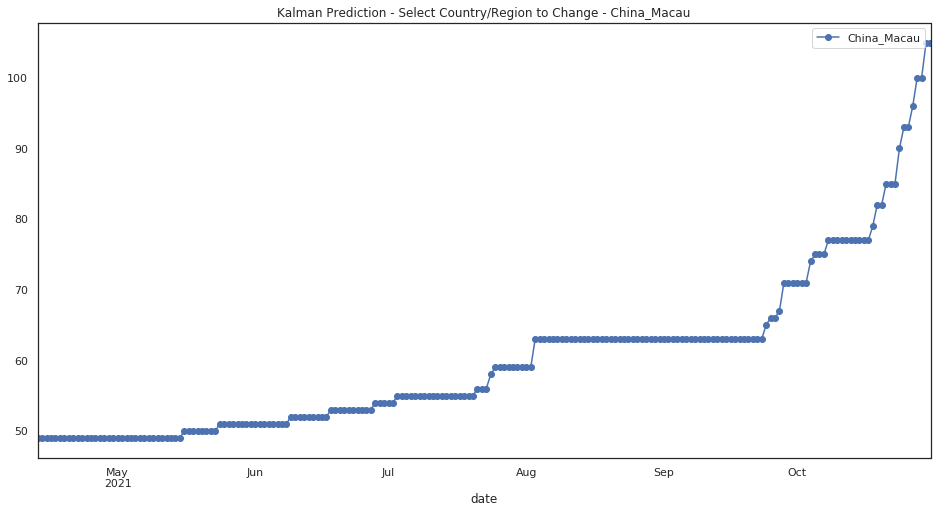

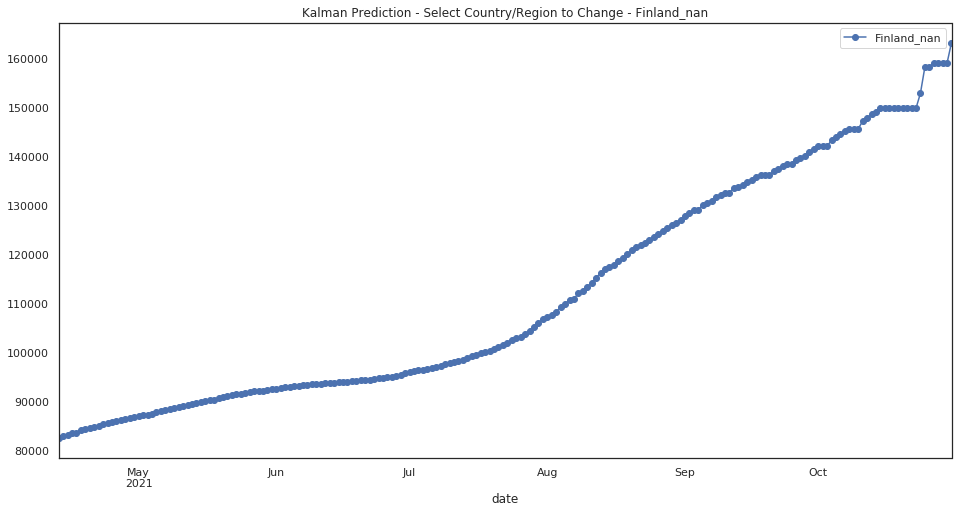

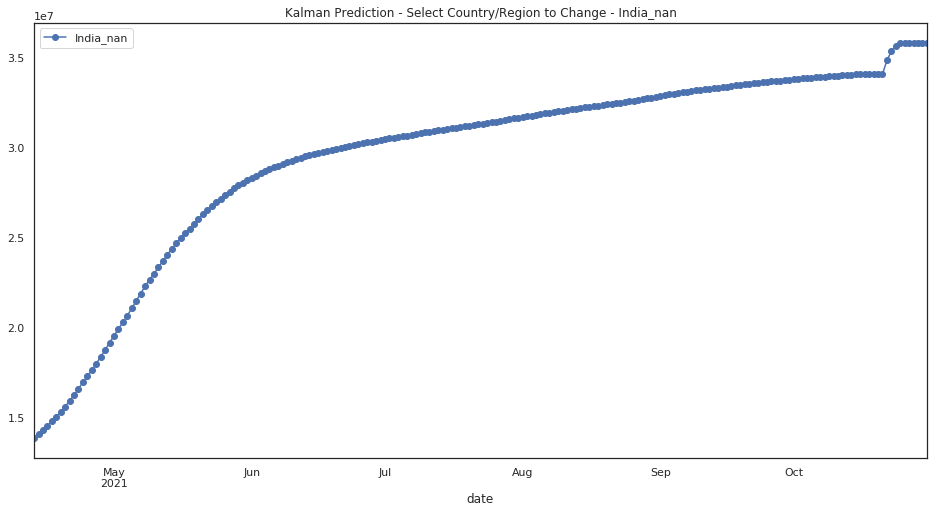

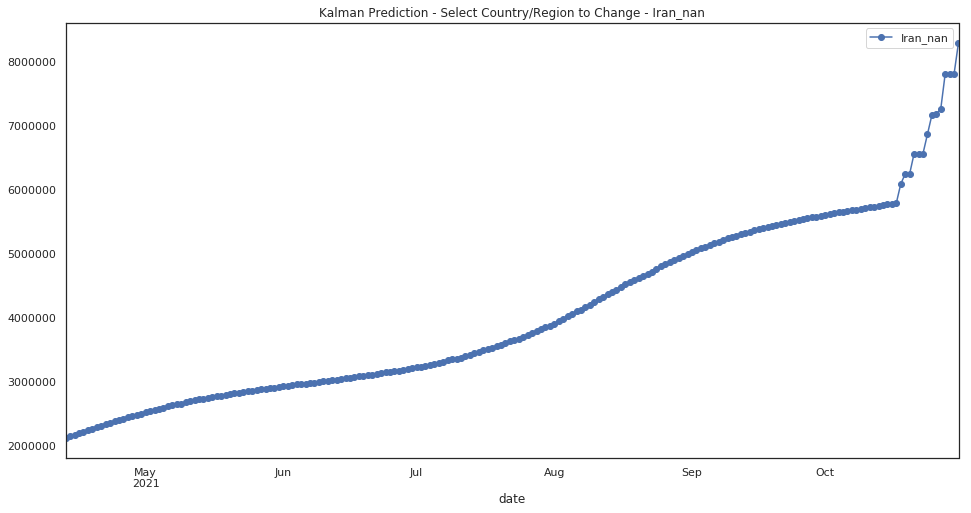

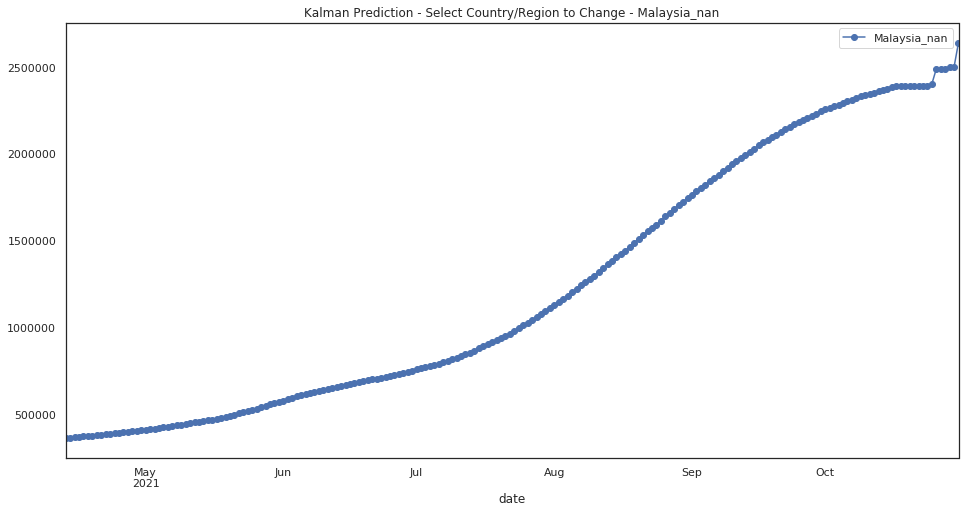

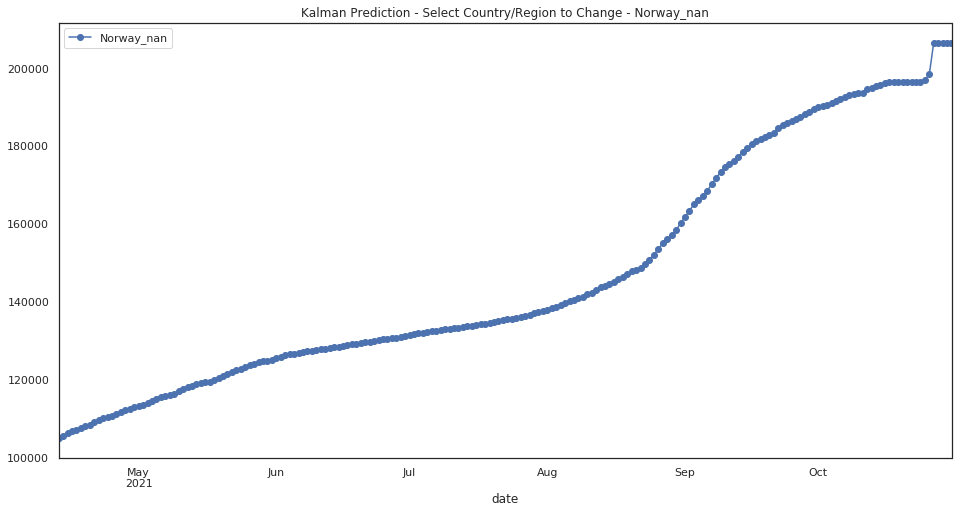

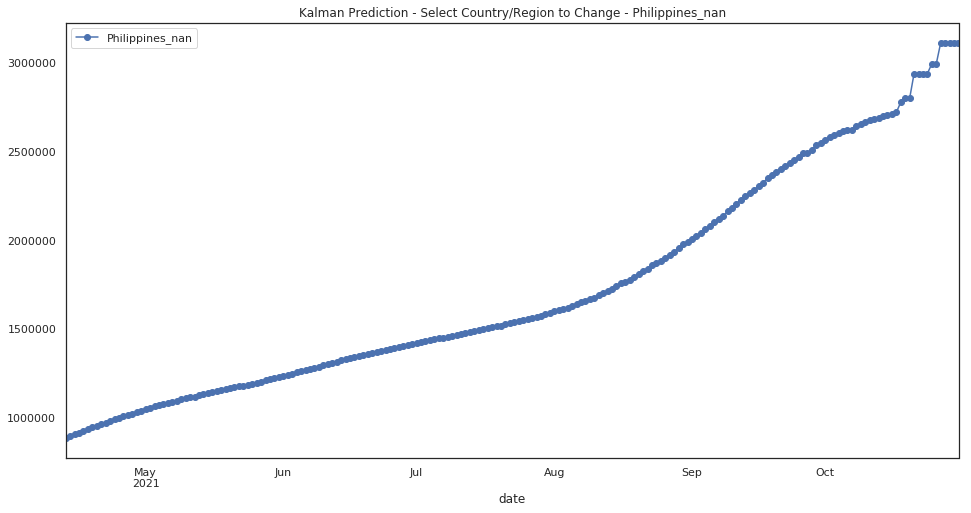

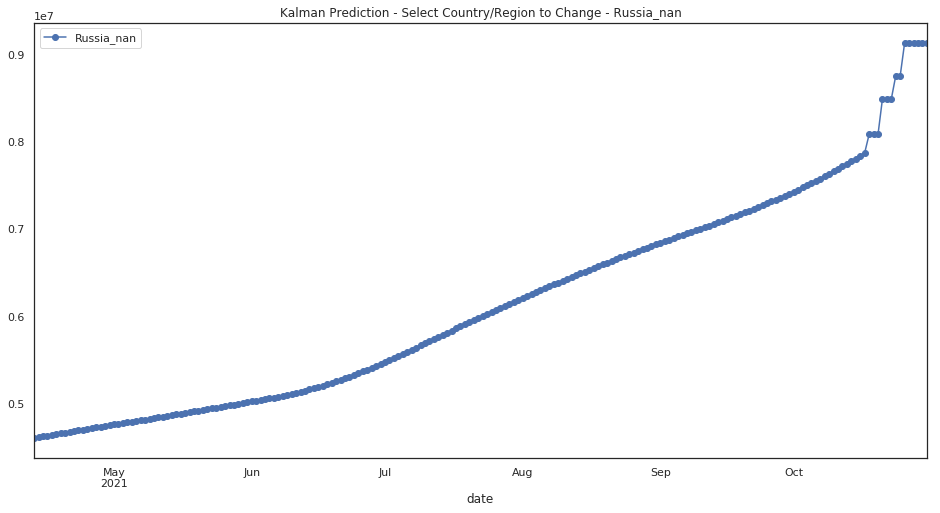

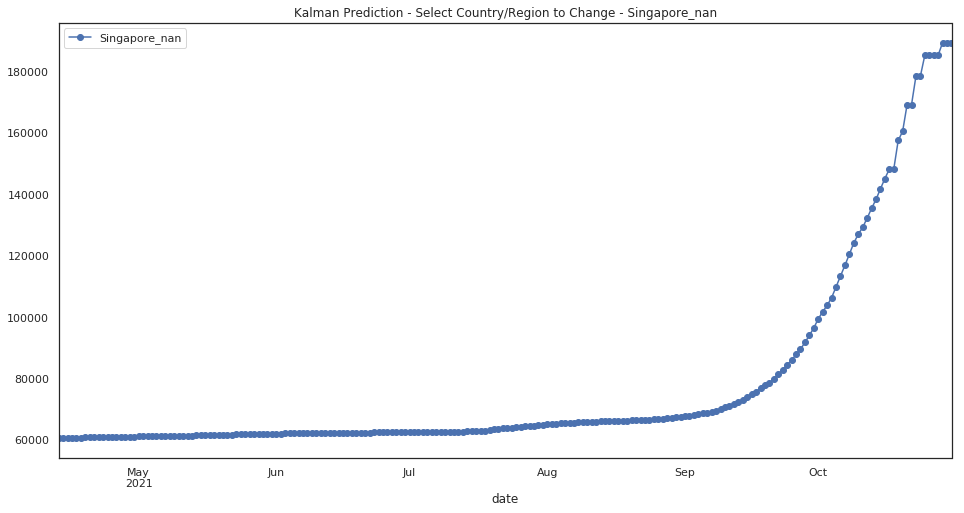

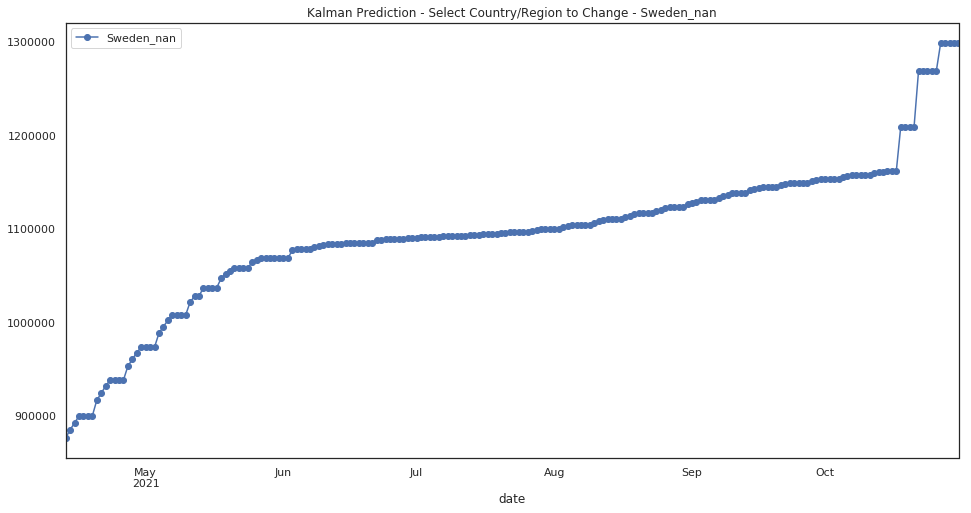

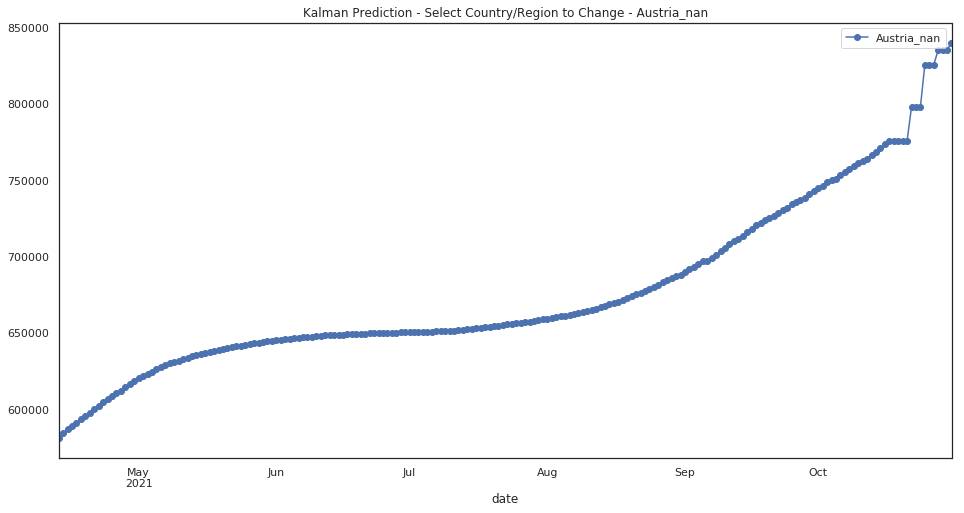

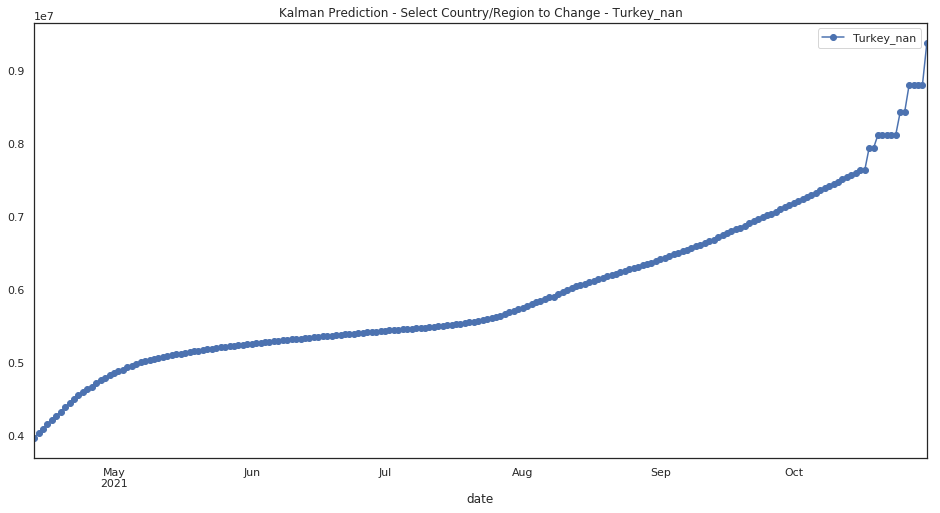

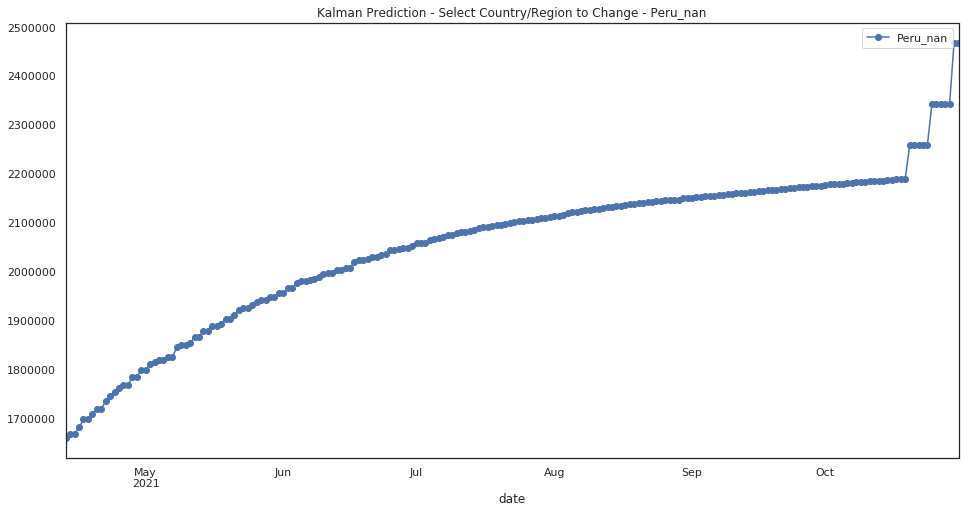

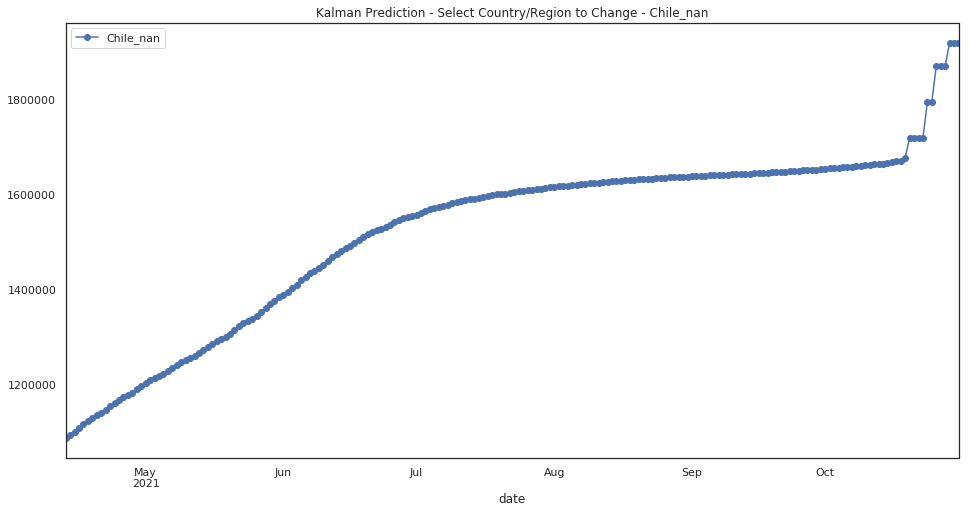

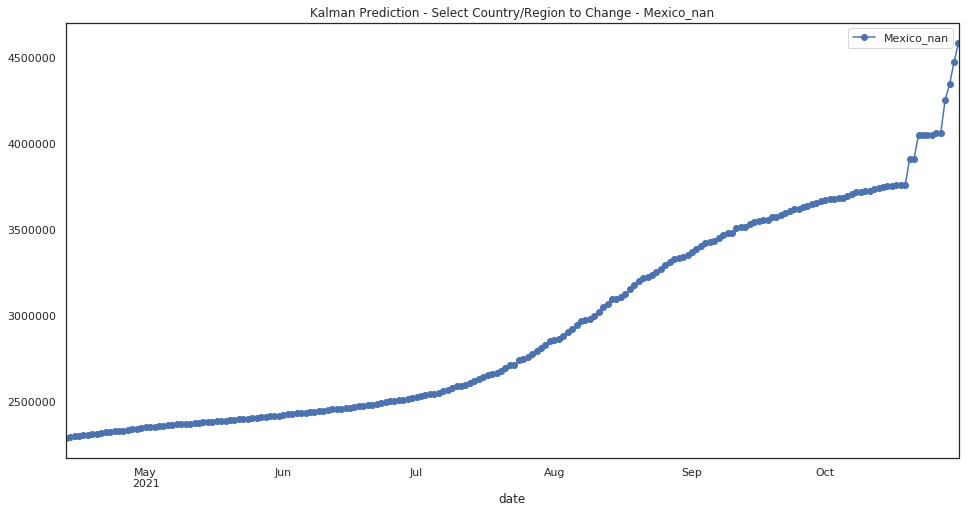

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2021-10-31 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      49542650.0
India_nan                                           NaN      35823520.0
Brazil_nan                                          NaN      24752347.0
United Kingdom_nan                                  NaN       9888618.0
Turkey_nan                                          NaN       9382657.0
Russia_nan                                          NaN       9132947.0
Iran_nan                                            NaN       8289972.0
France_nan                                          NaN       8150623.0
Colombia_nan                                        NaN       5832318.0
Argentina_nan                                       NaN       5746215.0
Spain_nan                                           NaN       5476360.0
Italy_nan                                           NaN       5390424.0
Germany_nan                                         NaN       5099664.0
Indonesia_nan                                       NaN       4725190.0
Mexico_nan                                          NaN       4586632.0
South Africa_nan                                    NaN       3478444.0
Poland_nan                                          NaN       3373538.0
Ukraine_nan                                         NaN       3240466.0
Philippines_nan                                     NaN       3113766.0
Malaysia_nan                                        NaN       2642737.0
Peru_nan                                            NaN       2468409.0
Netherlands_nan                                     NaN       2448678.0
Iraq_nan                                            NaN       2171442.0
Thailand_nan                                        NaN       2059747.0
Czechia_nan                                         NaN       1996601.0
Chile_nan                                           NaN       1920398.0
Japan_nan                                           NaN       1881413.0
Romania_nan                                         NaN       1831344.0
Bangladesh_nan                                      NaN       1652015.0
Belgium_nan                                         NaN       1619426.0
...                                                 ...             ...
Canada_Prince Edward Island                         NaN           359.0
China_Guangxi                                       NaN           346.0
Australia_Tasmania                                  NaN           295.0
Australia_Northern Territory                        NaN           292.0
China_Shanxi                                        NaN           290.0
China_Hainan                                        NaN           241.0
China_Guizhou                                       NaN           224.0
China_Gansu                                         NaN           220.0
China_Macau                                         NaN           105.0
United Kingdom_Falkland Islands (Malvinas)          NaN            91.0
China_Ningxia                                       NaN            84.0
United Kingdom_Montserrat                           NaN            49.0
China_Unknown                                       NaN            37.0
France_Saint Pierre and Miquelon                    NaN            37.0
Holy See_nan                                        NaN            35.0
Solomon Islands_nan                                 NaN            24.0
China_Qinghai                                       NaN            20.0
Palau_nan                                           NaN            17.0
Canada_Repatriated Travellers                       NaN            16.0
Canada_Grand Princess                               NaN            13.0
MS Zaandam_nan                                      NaN             9.0
United Kingdom_Saint Helena, Ascension and Tris...  NaN             4.0
Marshall Islands_nan                                NaN             4.0
Vanuatu_nan                                         NaN             4.0
Samoa_nan             

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-04-13         133665.0     195004.0     186452.0      95215.0   
2021-04-14         133775.0     195181.0     186603.0      95238.0   
2021-04-15          57492.0     128959.0     118975.0      12641.0   
2021-04-16          57534.0     129128.0     119142.0      12641.0   
2021-04-17          58000.0     129307.0     119717.0      12712.0   
2021-04-18          58030.0     129456.0     119886.0      12771.0   
2021-04-19          58187.0     129594.0     120052.0      12805.0   
2021-04-20          58275.0     129694.0     120230.0      12805.0   
2021-04-21          59506.0     130781.0     121507.0      12874.0   
2021-04-22          59570.0     130920.0     121699.0      12917.0   
2021-04-23          59897.0     131076.0     121894.0      12942.0   
2021-04-24          59911.0     131203.0     122066.0      13007.0   
2021-04-25          60099.0     131342.0     122266.0      13024.0   
2021-04-26          60373.0     131425.0     122448.0      13060.0   
2021-04-27          60491.0     131578.0     122672.0      13083.0   
2021-04-28          60595.0     131664.0     122883.0      13121.0   
2021-04-29          60887.0     131786.0     123162.0      13148.0   
2021-04-30          60981.0     131899.0     123383.0      13198.0   
2021-05-01          61219.0     132004.0     123622.0      13232.0   
2021-05-02          61373.0     132067.0     123857.0      13232.0   
2021-05-03          61568.0     132132.0     124046.0      13282.0   
2021-05-04          61827.0     132186.0     124324.0      13295.0   
2021-05-05          61954.0     132261.0     124546.0      13316.0   
2021-05-06          62348.0     132328.0     124766.0      13340.0   
2021-05-07          62488.0     132400.0     125029.0      13363.0   
2021-05-08          62894.0     132501.0     125224.0      13390.0   
2021-05-09          63010.0     132548.0     125433.0      13406.0   
2021-05-10          63481.0     132600.0     125622.0      13423.0   
2021-05-11          63619.0     132661.0     125827.0      13429.0   
2021-05-12          63782.0     132691.0     126016.0      13447.0   
...                     ...          ...          ...          ...   
2021-10-03         156609.0     172274.0     205136.0      15222.0   
2021-10-04         156689.0     172367.0     205265.0      15222.0   
2021-10-05         156676.0     173261.0     205396.0      15267.0   
2021-10-06         156778.0     173503.0     205519.0      15271.0   
2021-10-07         156809.0     174156.0     205629.0      15284.0   
2021-10-08         156841.0     174647.0     205746.0      15288.0   
2021-10-09         156875.0     175139.0     205845.0      15291.0   
2021-10-10         156912.0     175465.0     205954.0      15291.0   
2021-10-11         156933.0     175735.0     206051.0      15291.0   
2021-10-12         156993.0     176244.0     206149.0      15307.0   
2021-10-13         157014.0     176609.0     206257.0      15307.0   
2021-10-14         157080.0     177106.0     206357.0      15314.0   
2021-10-15         157080.0     177569.0     206461.0      15326.0   
2021-10-16         157147.0     178019.0     206557.0      15338.0   
2021-10-17         157154.0     178453.0     206647.0      15338.0   
2021-10-18         157170.0     178509.0     206660.0      15338.0   
2021-10-19         157736.0     178681.0     206688.0      15645.0   
2021-10-20         162423.0     178659.0     206684.0      15645.0   
2021-10-21         164805.0     183311.0     208520.0      15742.0   
2021-10-22         170846.0     183410.0     208120.0      15742.0   
2021-10-23         178337.0     185341.0     211566.0      15742.0   
2021-10-24         182226.0     185047.0     211005.0      15742.0   
2021-10-25         184601.0     189709.0     212505.0      15742.0   
2021-10-26         186287.0     193738.0     212415.0      15742.0   
2021-10-27

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'United Kingdom_nan',
 'Turkey_nan',
 'Russia_nan',
 'Iran_nan',
 'France_nan',
 'Colombia_nan',
 'Argentina_nan',
 'Spain_nan',
 'Italy_nan',
 'Germany_nan',
 'Indonesia_nan',
 'Mexico_nan',
 'South Africa_nan',
 'Poland_nan',
 'Ukraine_nan',
 'Philippines_nan',
 'Malaysia_nan',
 'Peru_nan',
 'Netherlands_nan',
 'Iraq_nan',
 'Thailand_nan',
 'Czechia_nan',
 'Chile_nan',
 'Japan_nan',
 'Romania_nan',
 'Bangladesh_nan',
 'Belgium_nan',
 'Pakistan_nan',
 'Israel_nan',
 'Sweden_nan',
 'Cuba_nan',
 'Serbia_nan',
 'Portugal_nan',
 'Kazakhstan_nan',
 'Greece_nan',
 'Switzerland_nan',
 'Vietnam_nan',
 'Morocco_nan',
 'Jordan_nan',
 'Nepal_nan',
 'Hungary_nan',
 'Austria_nan',
 'Tunisia_nan',
 'Canada_Ontario',
 'United Arab Emirates_nan',
 'Lebanon_nan',
 'Belarus_nan',
 'Georgia_nan',
 'Bulgaria_nan',
 'Costa Rica_nan',
 'Burma_nan',
 'Saudi Arabia_nan',
 'Guatemala_nan',
 'Sri Lanka_nan',
 'Ecuador_nan',
 'Bolivia_nan',
 'Azerbaijan_nan',


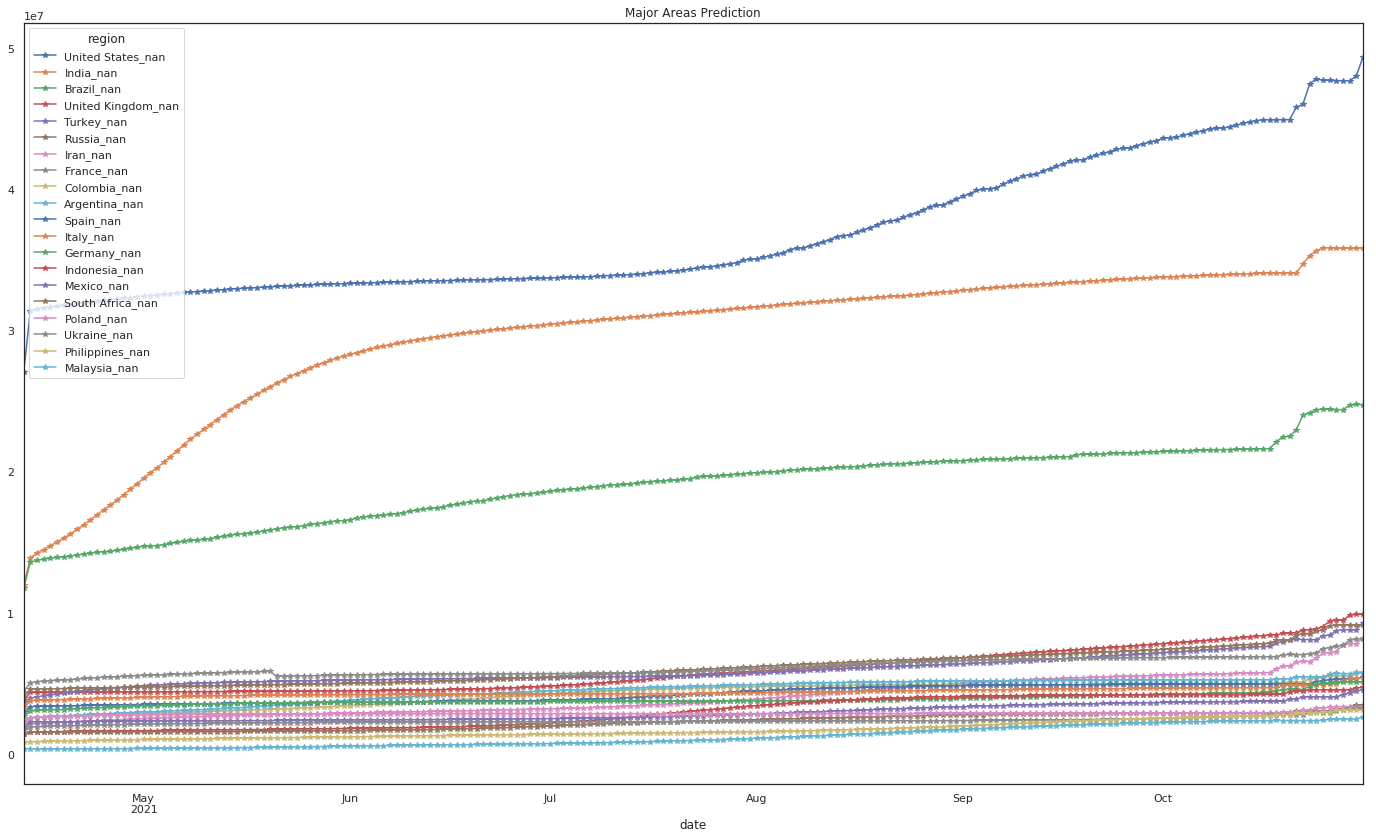

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

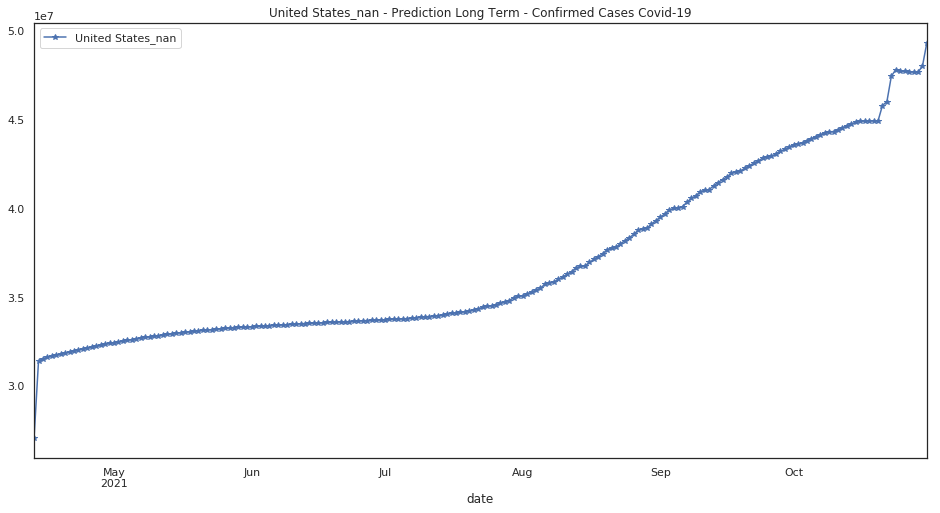

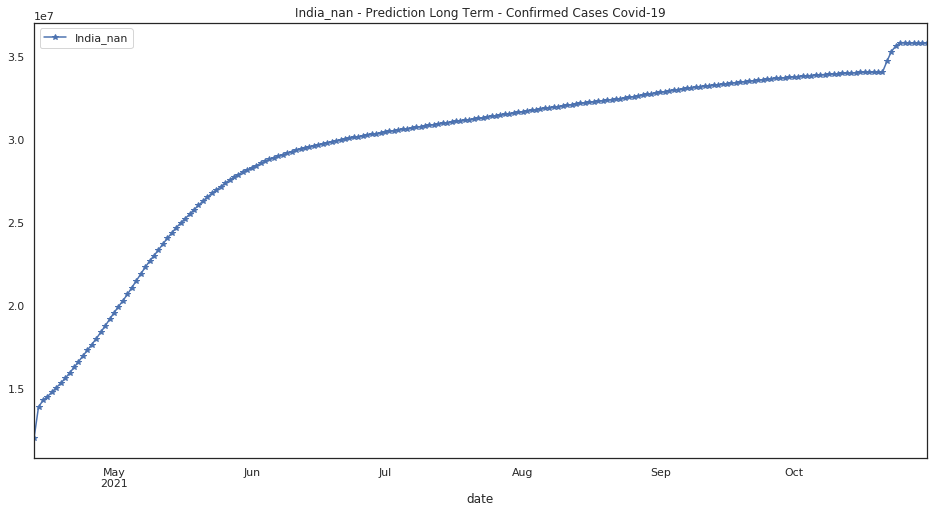

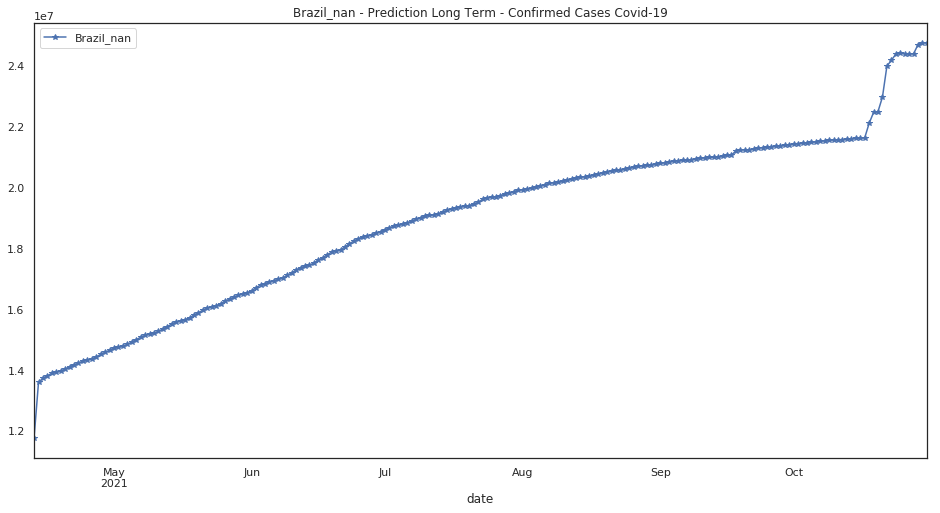

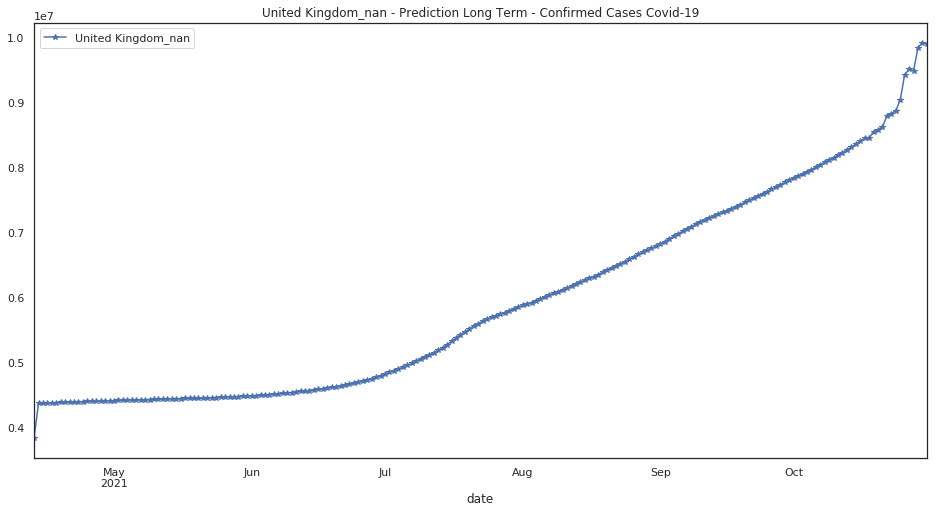

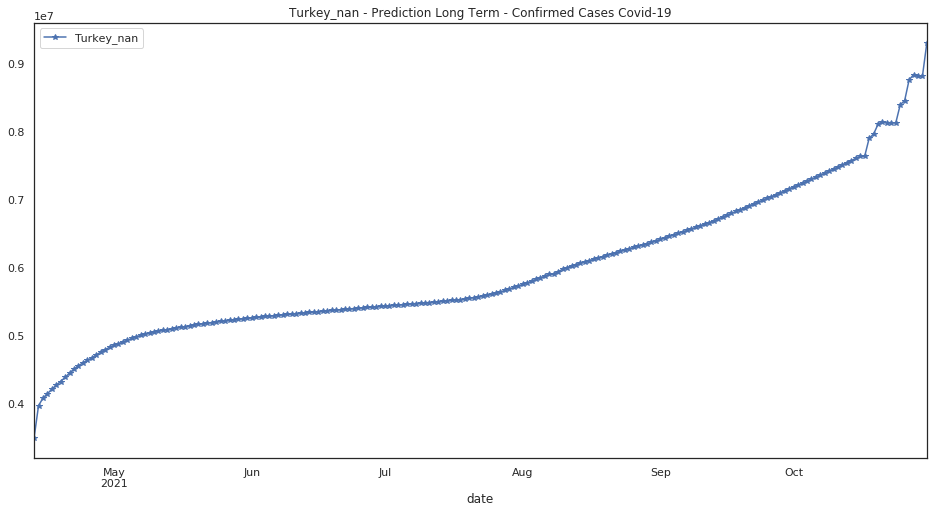

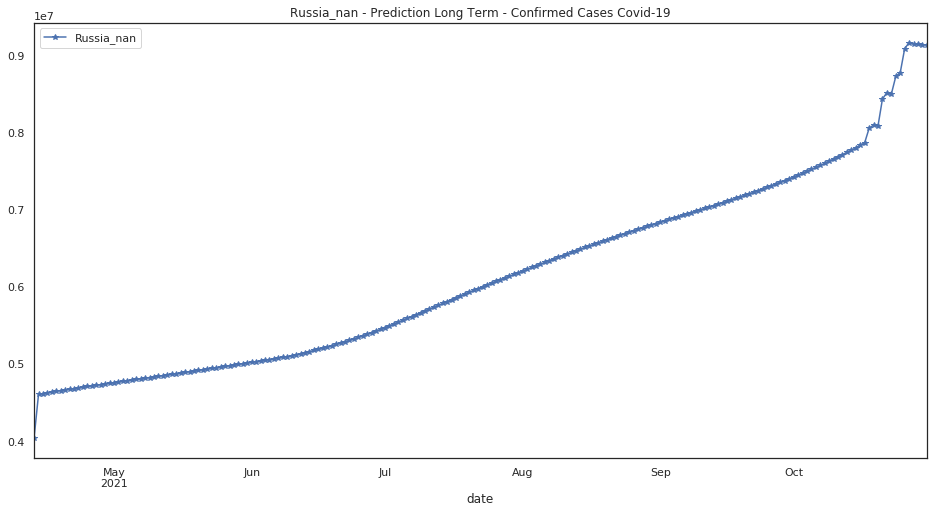

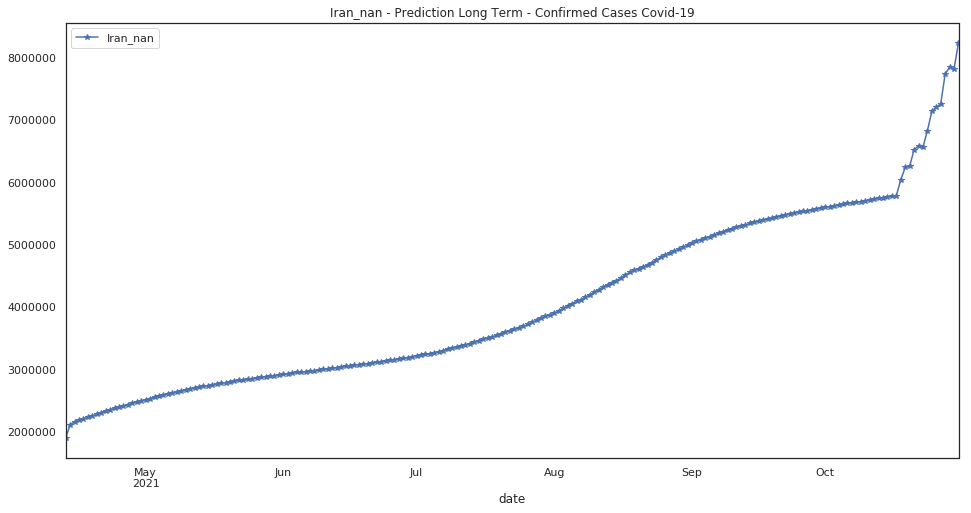

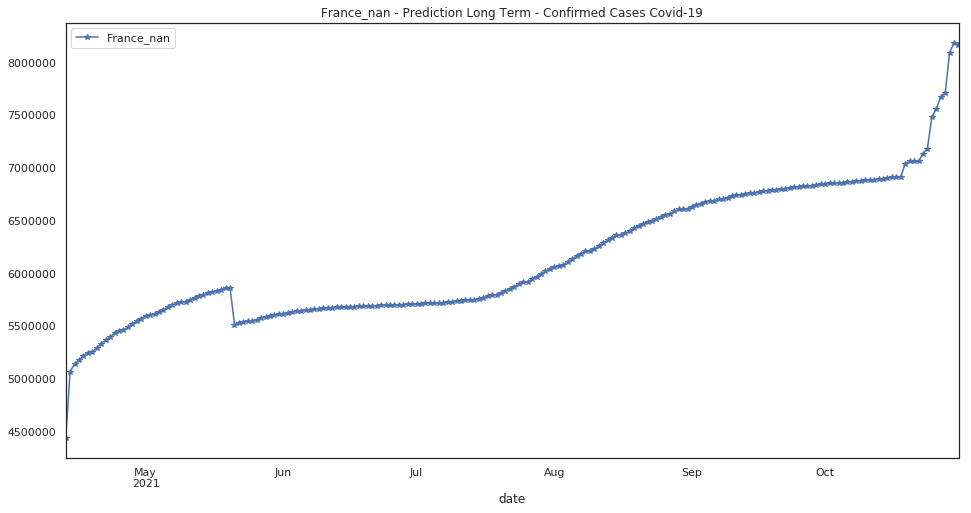

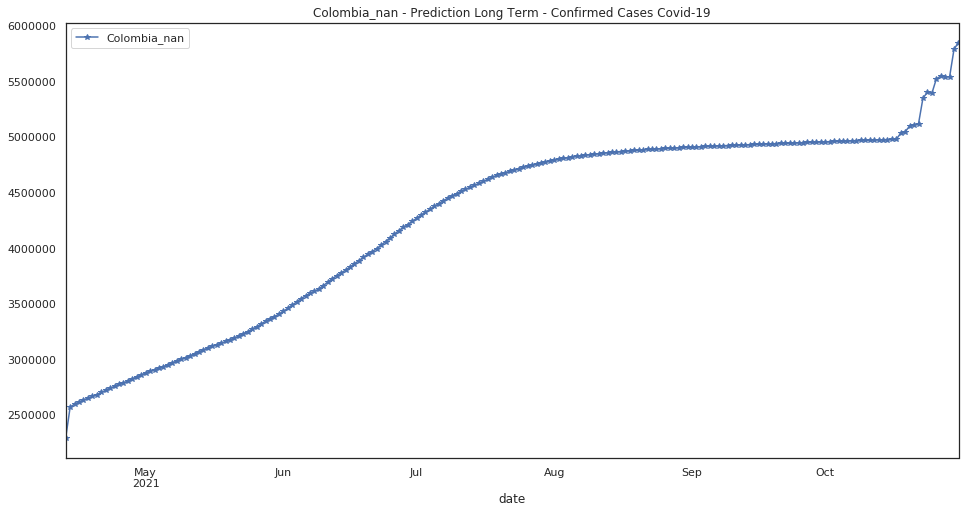

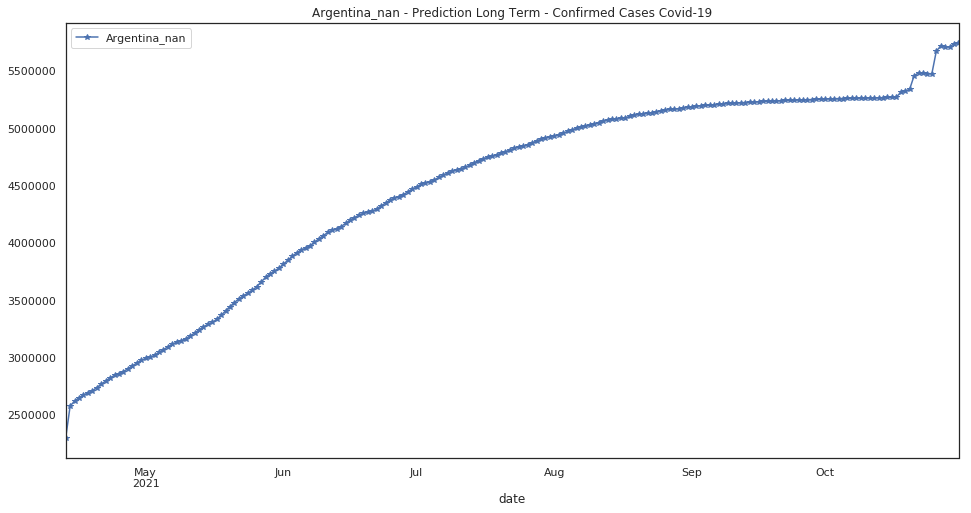

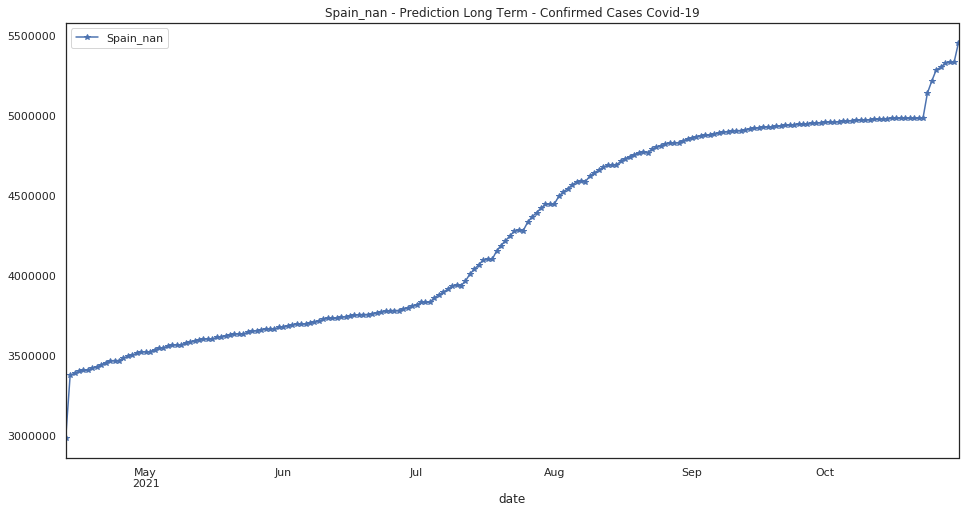

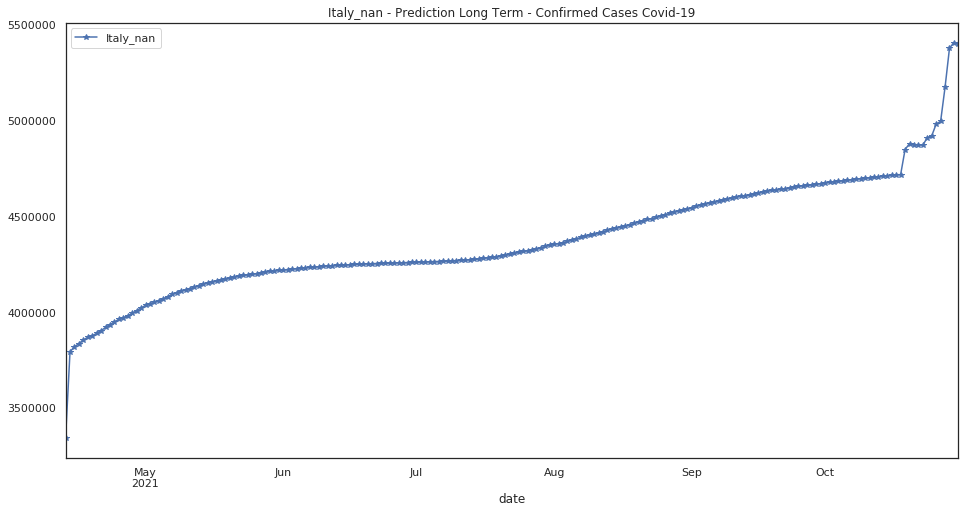

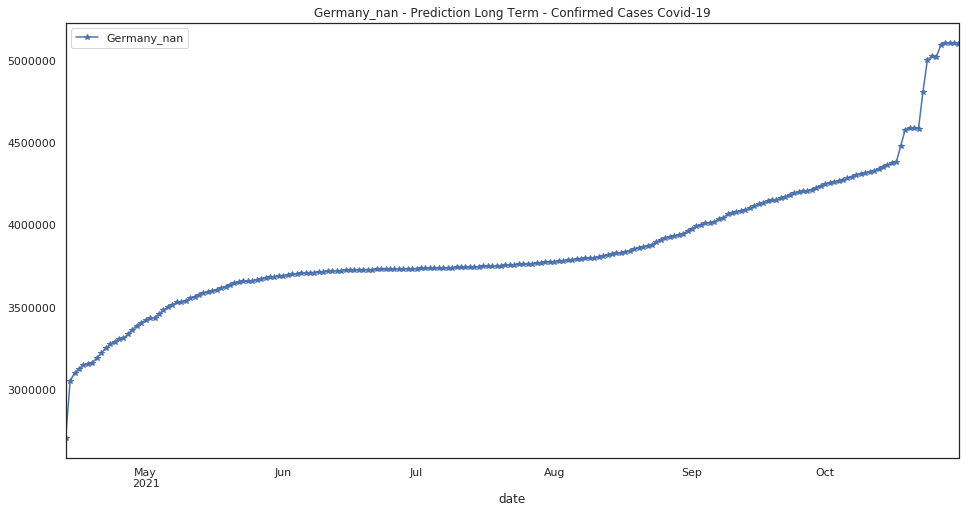

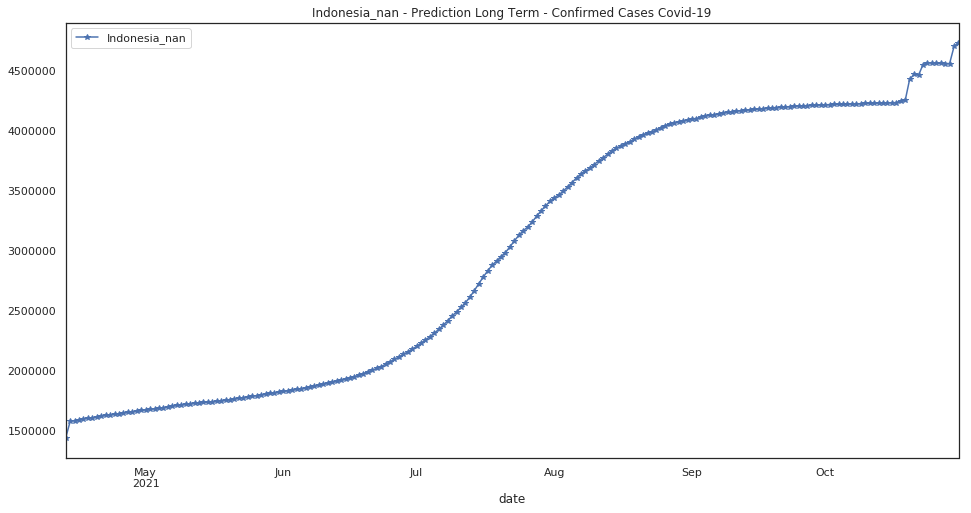

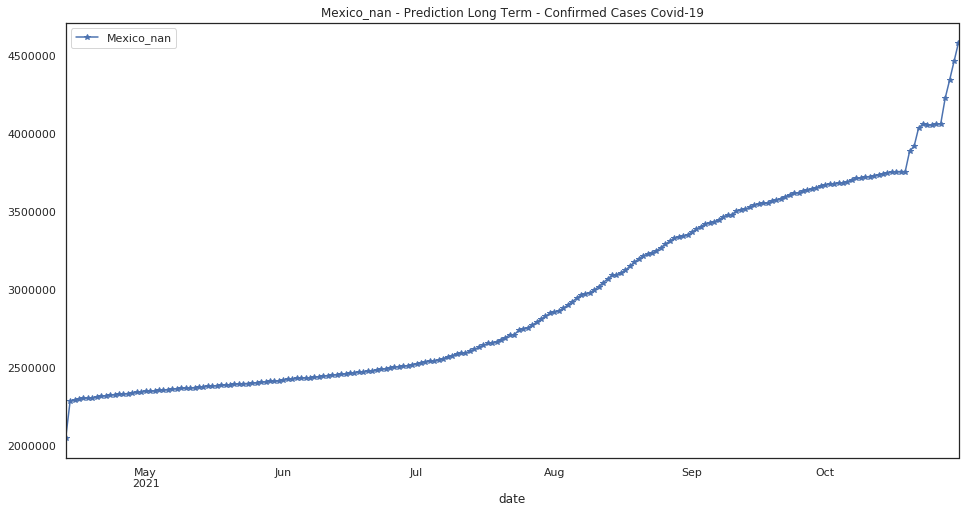

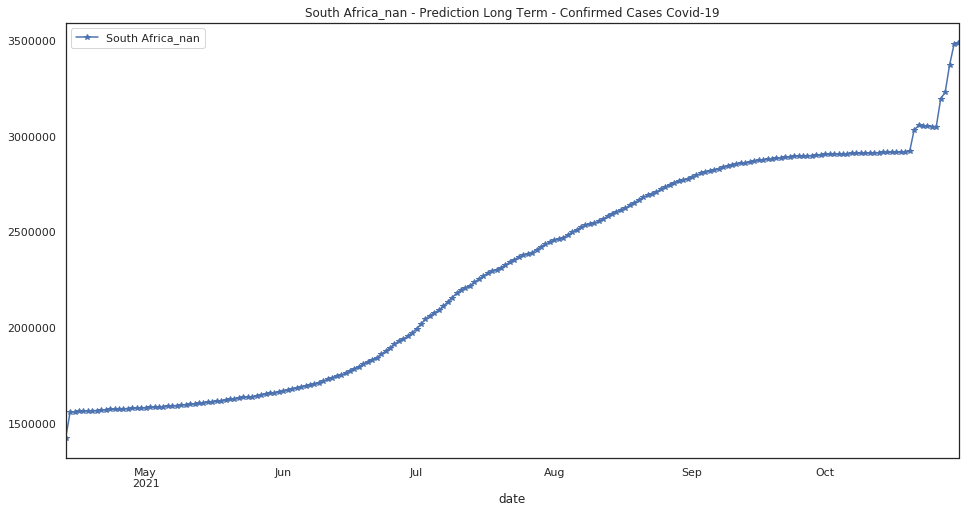

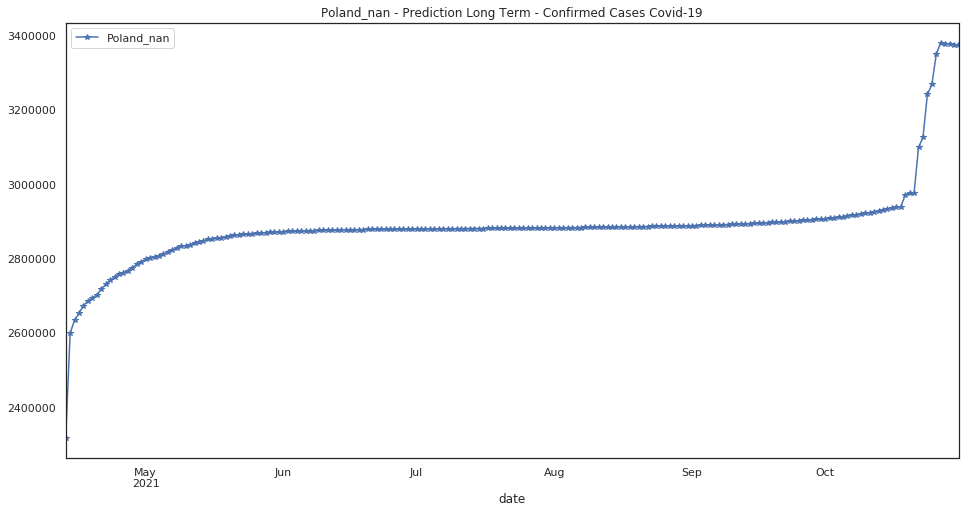

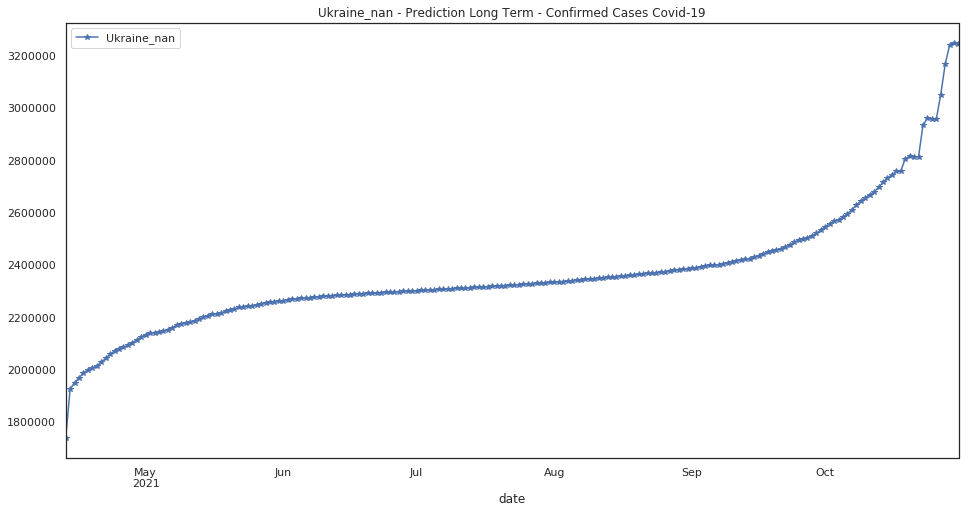

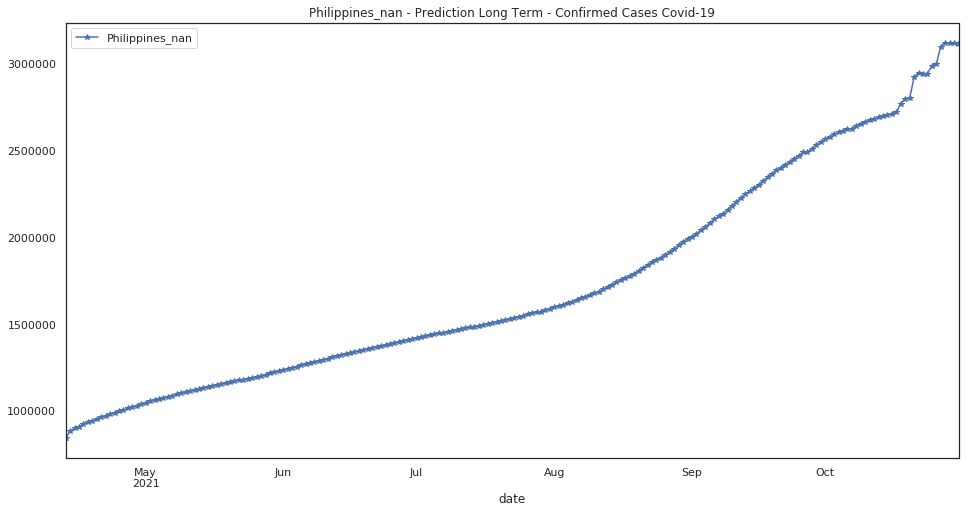

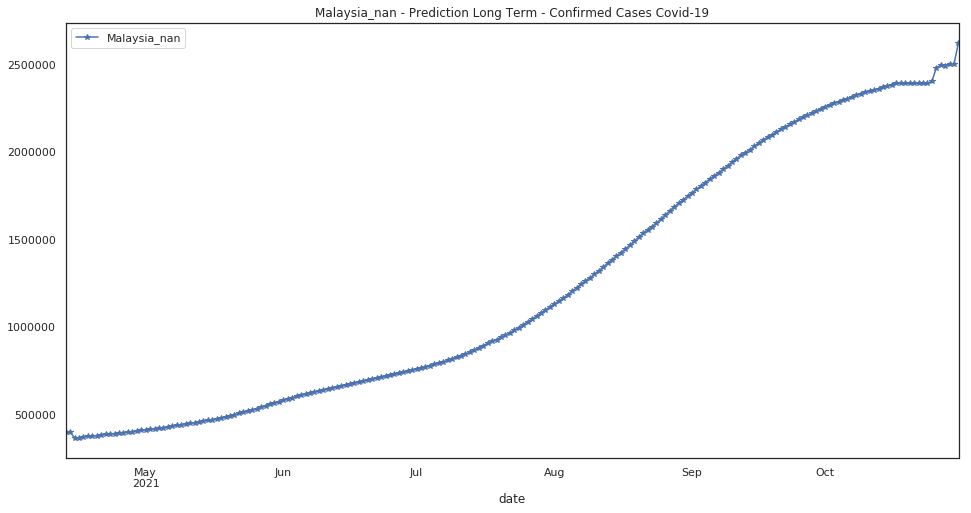

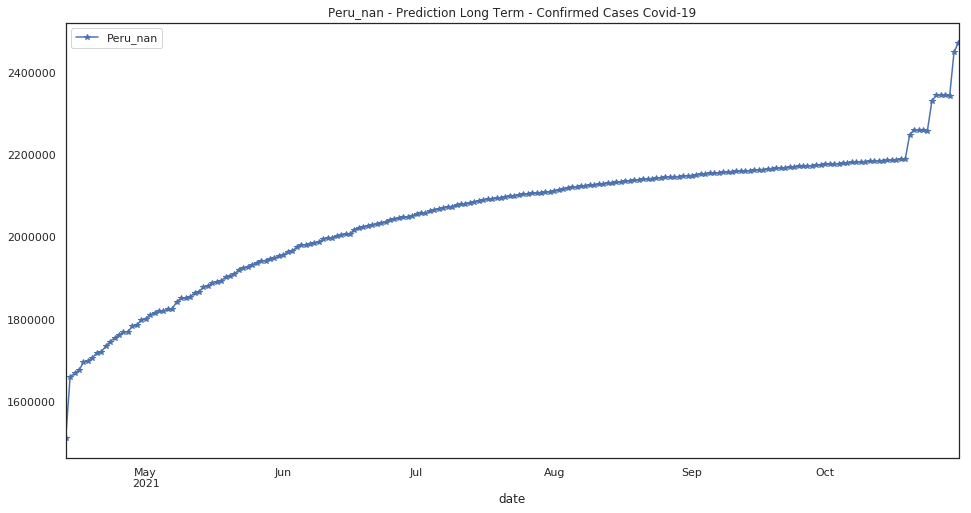

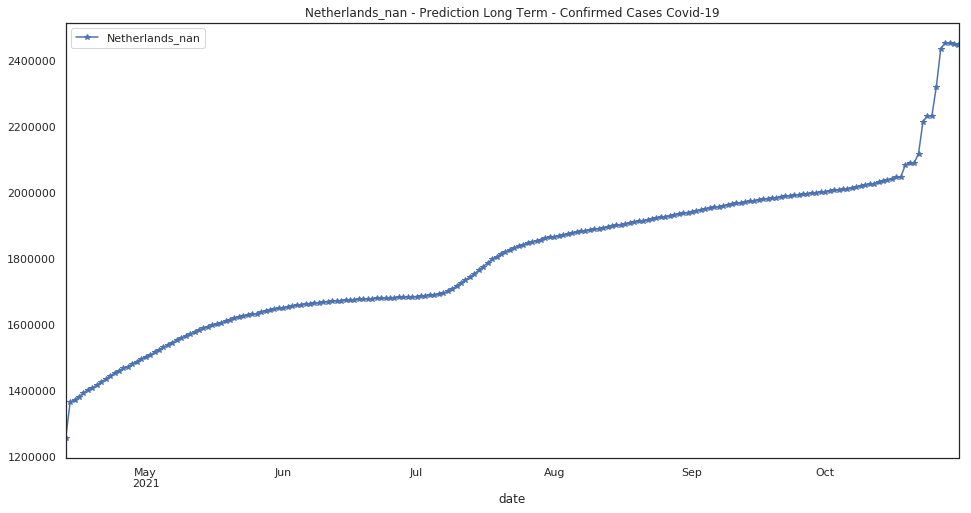

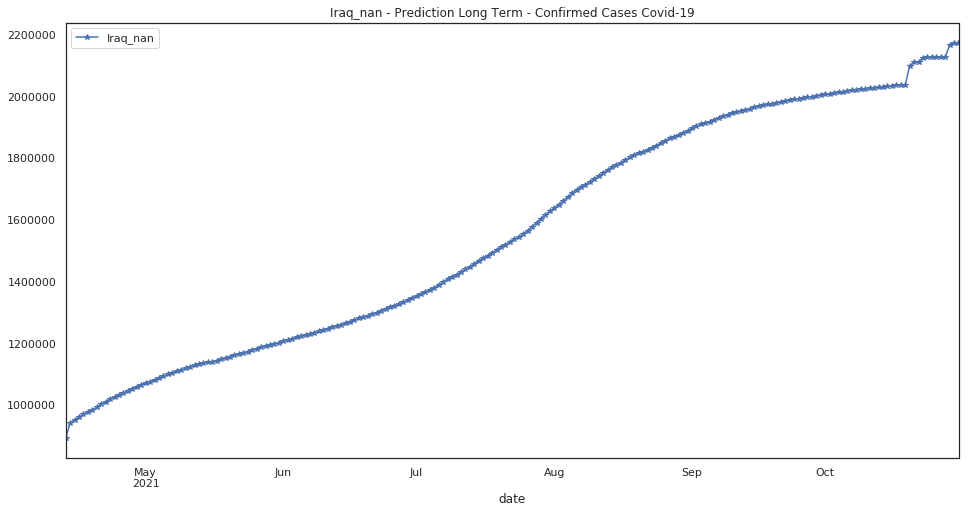

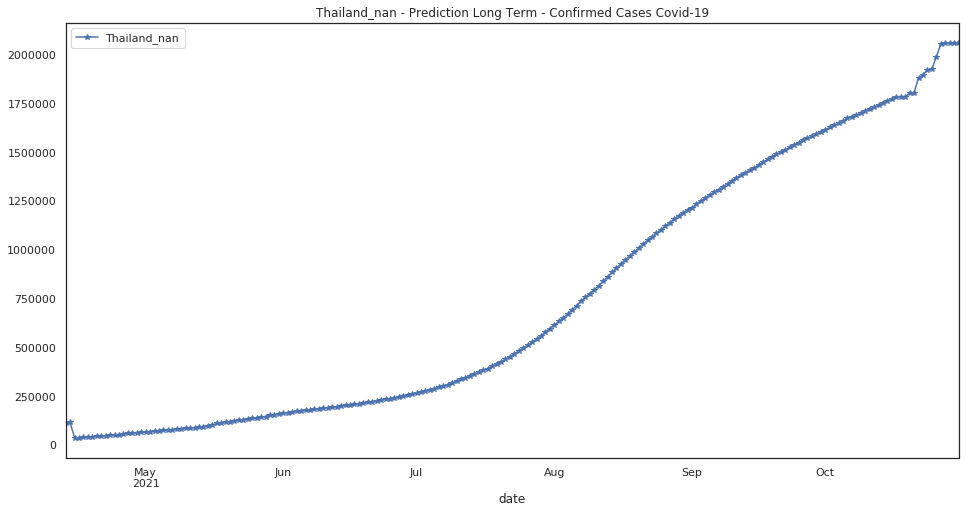

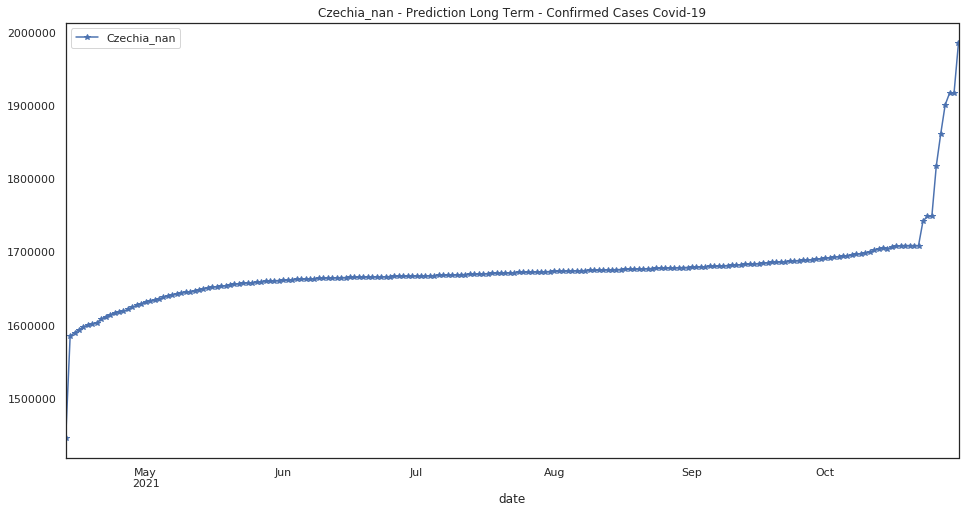

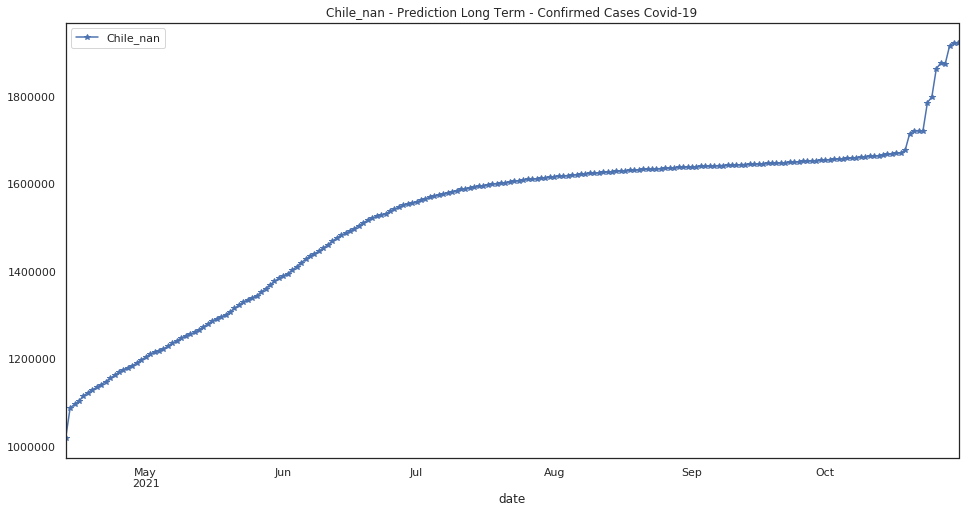

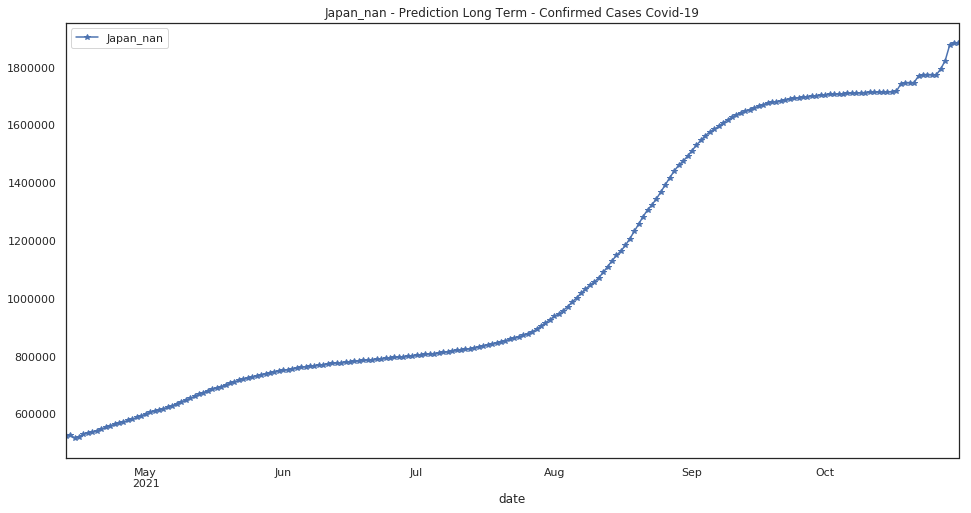

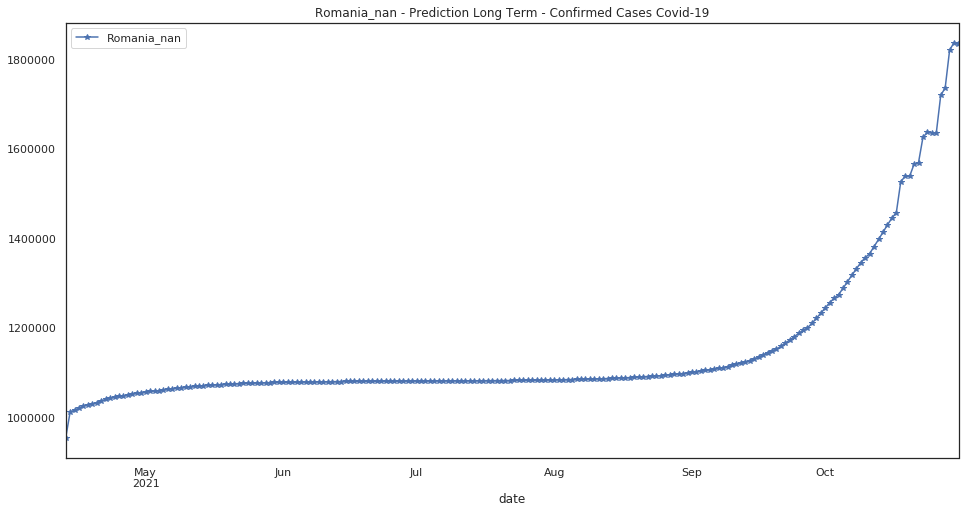

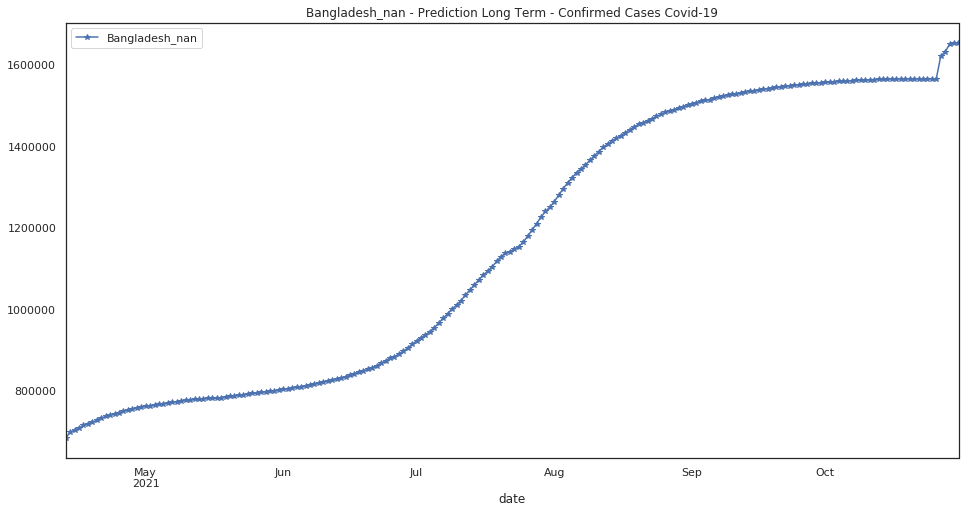

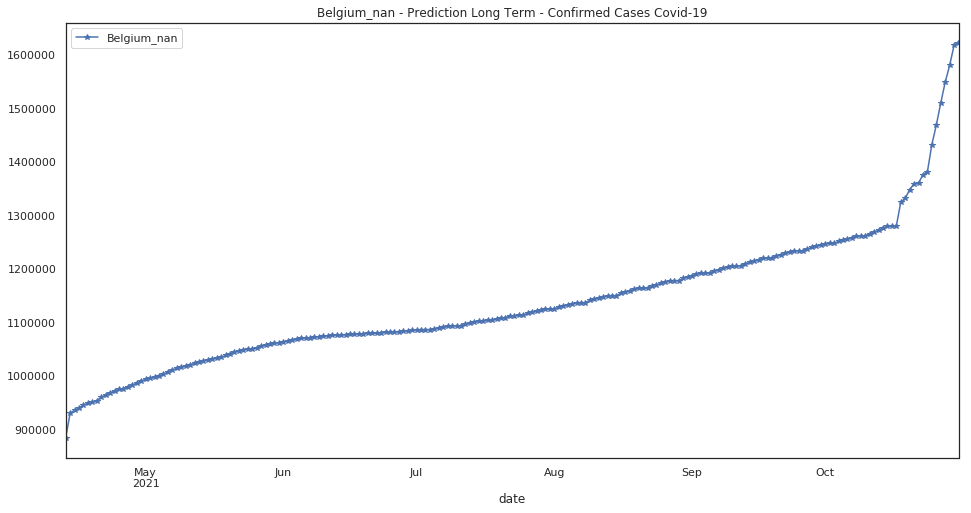

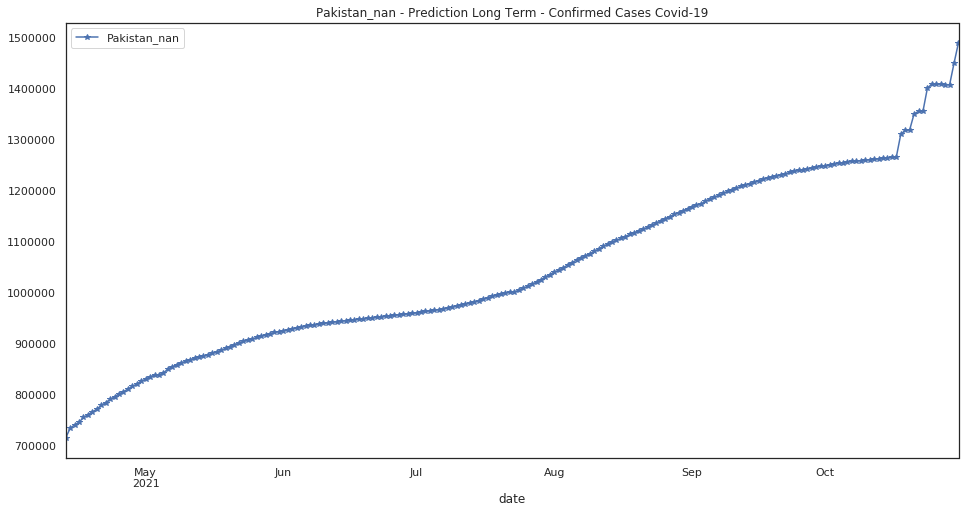

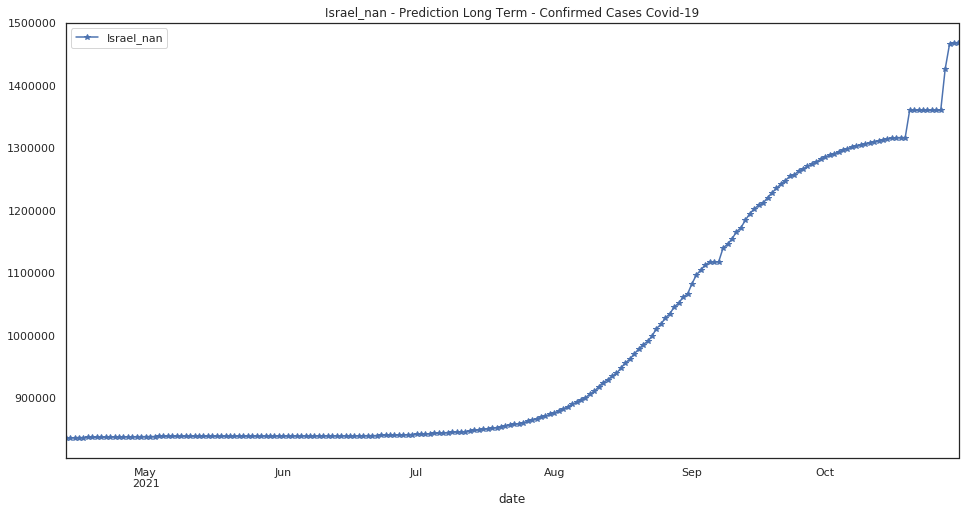

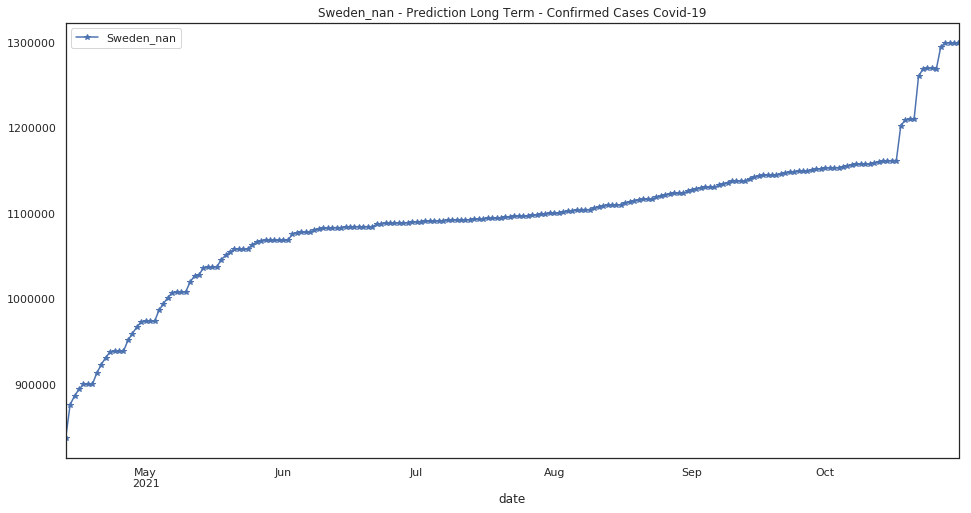

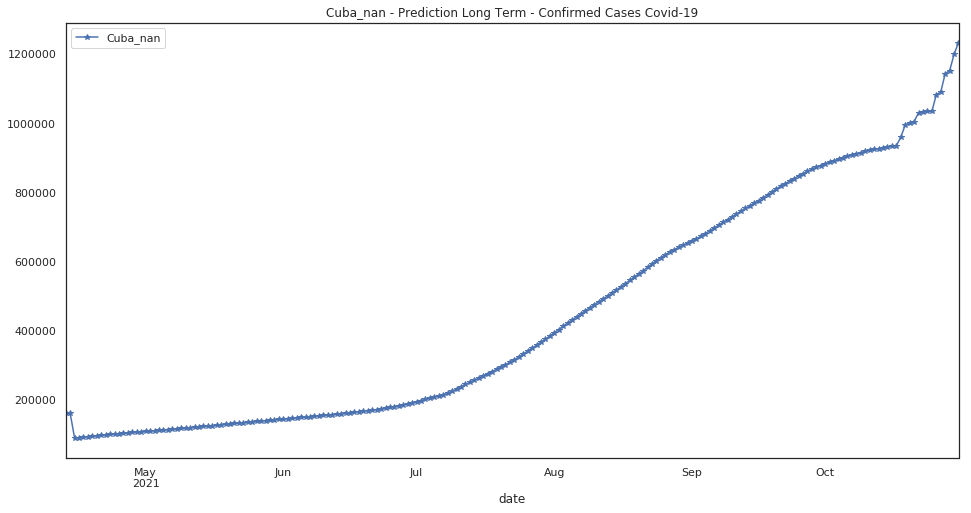

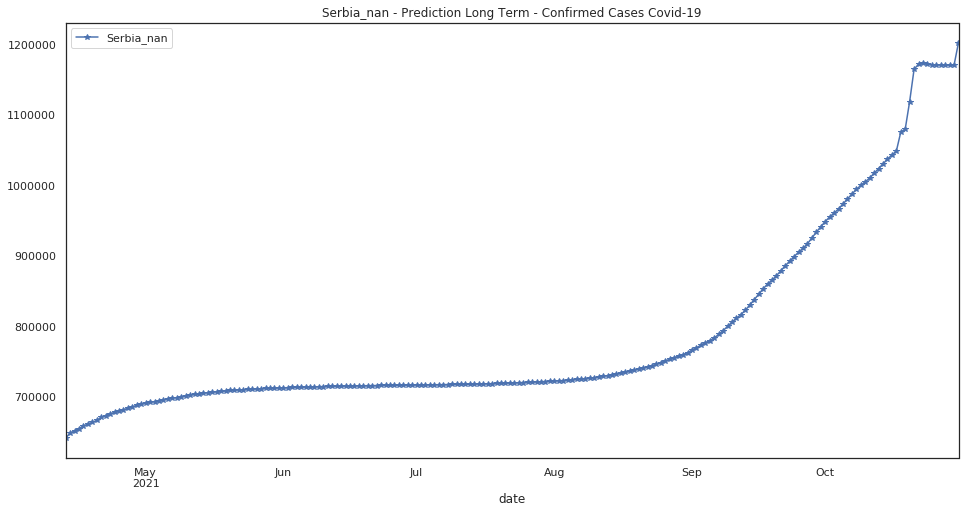

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

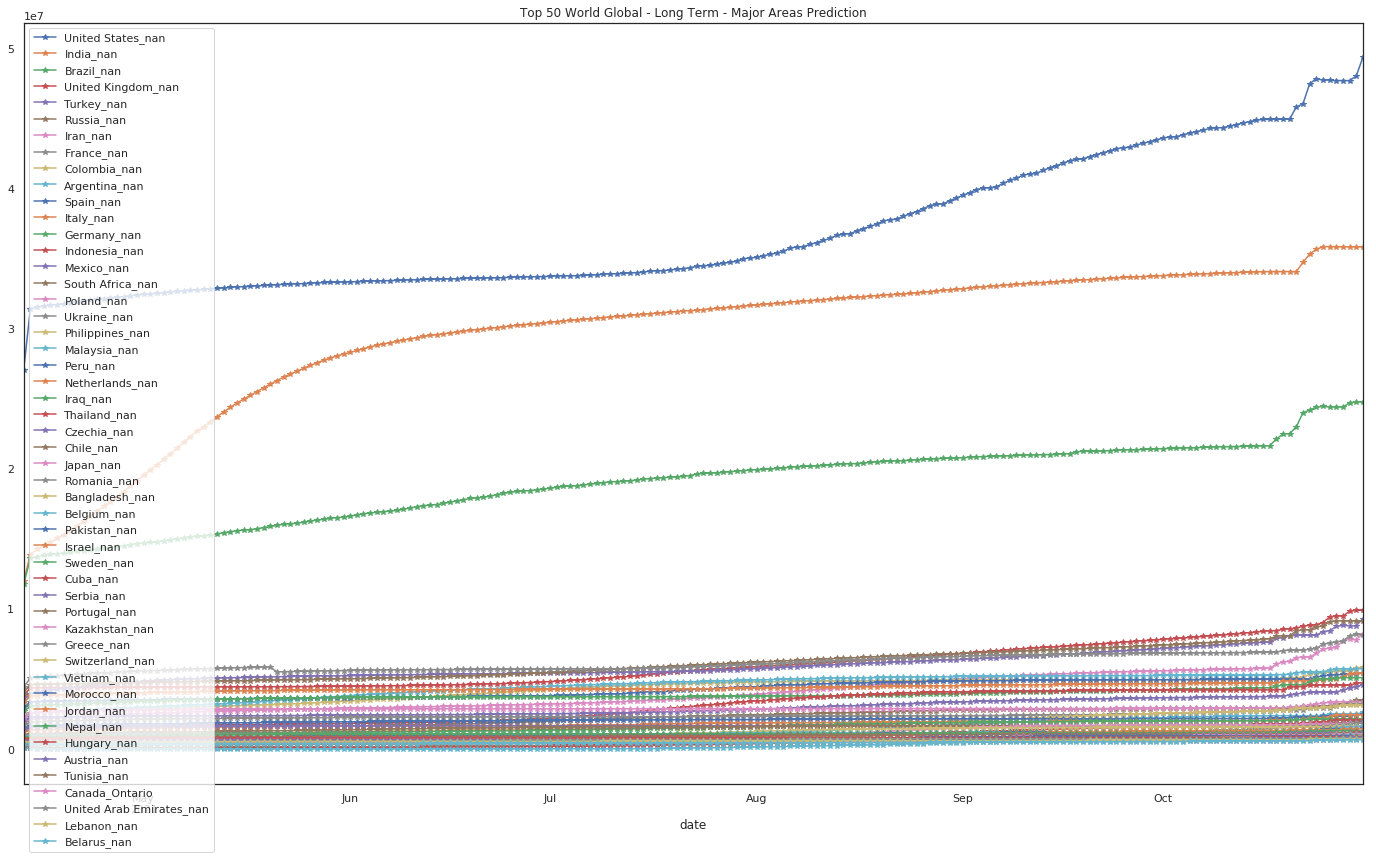

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

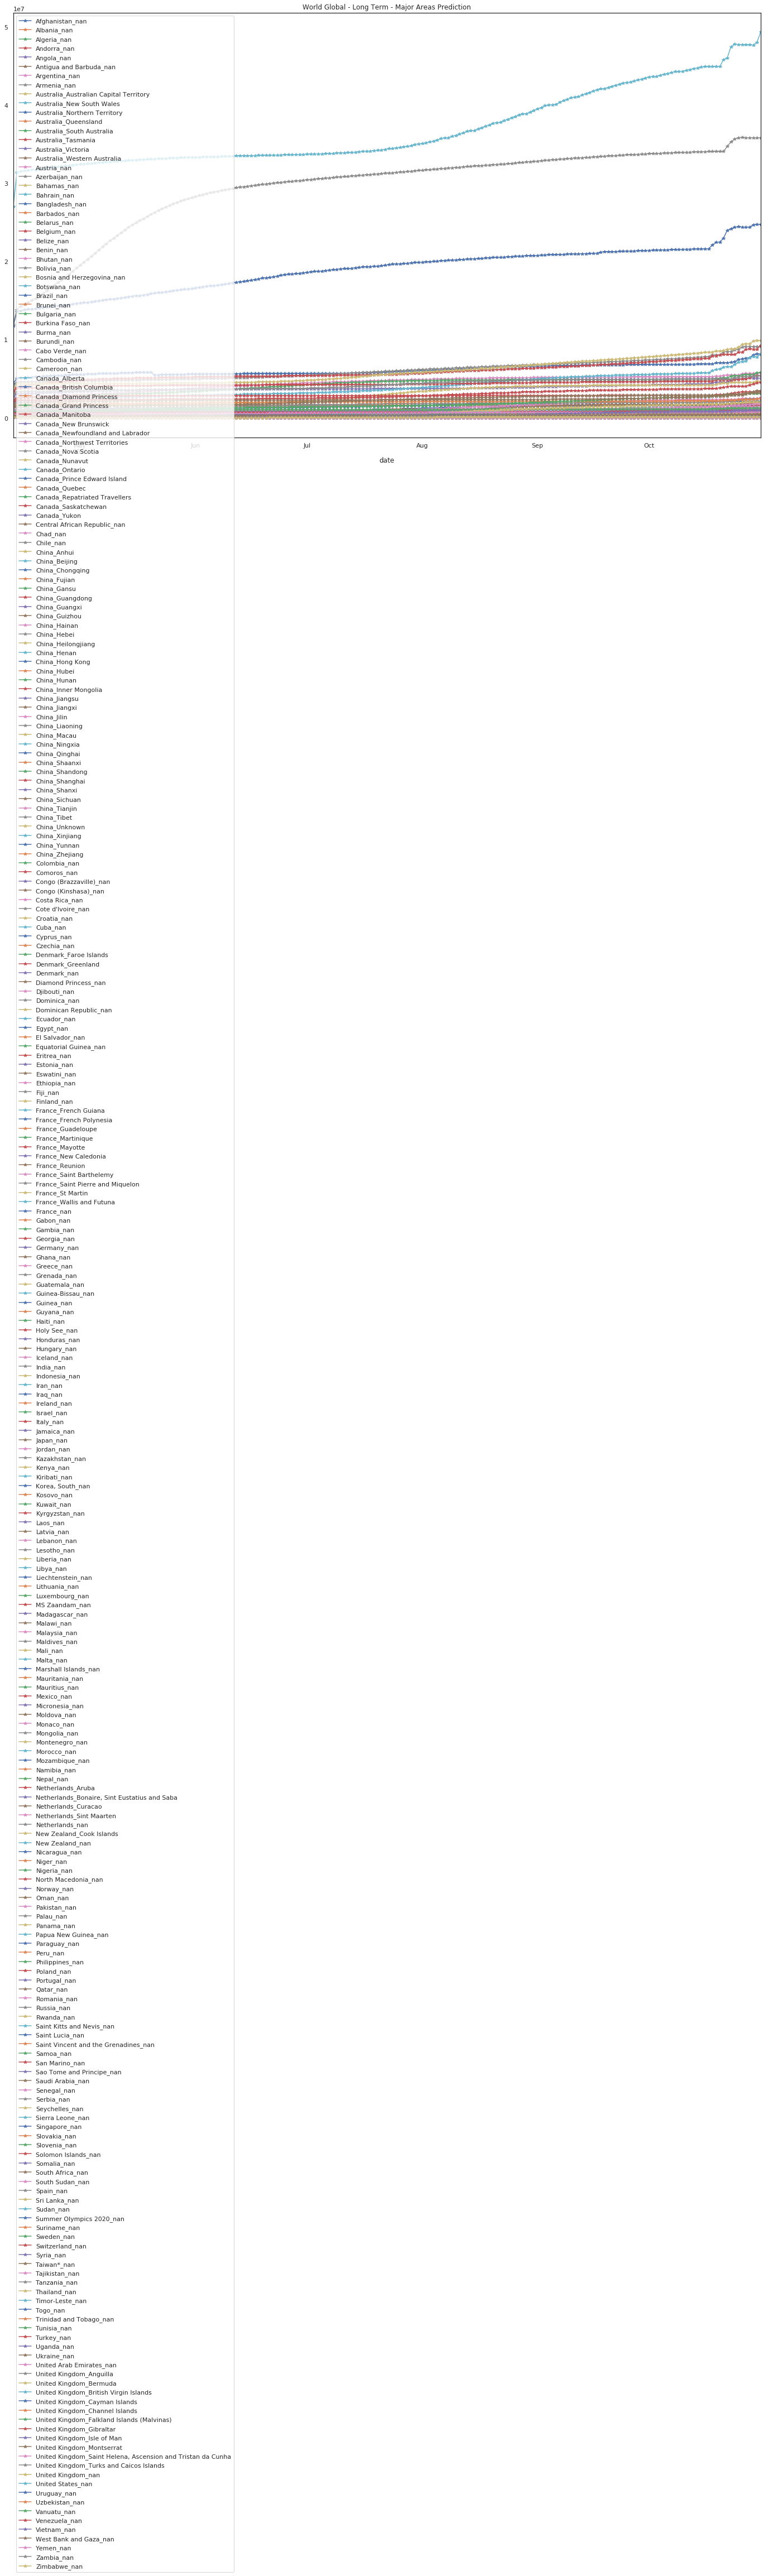

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-05-28          69956.0     133141.0     129484.0      13682.0   
2021-05-29          70755.0     133153.0     129750.0      13693.0   
2021-05-30          71221.0     133170.0     130026.0      13693.0   
2021-05-31          72659.0     133176.0     130219.0      13693.0   
2021-06-01          73323.0     133199.0     130554.0      13727.0   
2021-06-02          74352.0     133205.0     130889.0      13729.0   
2021-06-03          75590.0     133220.0     131173.0      13744.0   
2021-06-04          77017.0     133234.0     131612.0      13752.0   
2021-06-05          77970.0     133235.0     131917.0      13758.0   
2021-06-06          79485.0     133245.0     132237.0      13758.0   
2021-06-07          81177.0     133248.0     132579.0      13758.0   
2021-06-08          82342.0     133259.0     132908.0      13777.0   
2021-06-09          84214.0     133272.0     133271.0      13781.0   
2021-06-10          85863.0     133282.0     133592.0      13791.0   
2021-06-11          87633.0     133297.0     133997.0      13805.0   
2021-06-12          88846.0     133309.0     134313.0      13813.0   
2021-06-13          90691.0     133318.0     134651.0      13813.0   
2021-06-14          92093.0     133323.0     135016.0      13813.0   
2021-06-15          93434.0     133334.0     135364.0      13826.0   
2021-06-16          93578.0     133337.0     135702.0      13828.0   
2021-06-17          97887.0     133343.0     136097.0      13836.0   
2021-06-18          97499.0     133348.0     136456.0      13839.0   
2021-06-19         100351.0     133352.0     136827.0      13842.0   
2021-06-20         102286.0     133354.0     137089.0      13842.0   
2021-06-21         104452.0     133355.0     137600.0      13842.0   
2021-06-22         105835.0     133361.0     137862.0      13864.0   
2021-06-23         108139.0     133359.0     138288.0      13864.0   
2021-06-24         109630.0     133364.0     138659.0      13873.0   
2021-06-25         112074.0     133370.0     139030.0      13877.0   
2021-06-26         113338.0     133370.0     139366.0      13882.0   
...                     ...          ...          ...          ...   
2021-10-02         156601.0     171759.0     204997.0      15222.0   
2021-10-03         156609.0     172274.0     205136.0      15222.0   
2021-10-04         156689.0     172367.0     205265.0      15222.0   
2021-10-05         156676.0     173261.0     205396.0      15267.0   
2021-10-06         156778.0     173503.0     205519.0      15271.0   
2021-10-07         156809.0     174156.0     205629.0      15284.0   
2021-10-08         156841.0     174647.0     205746.0      15288.0   
2021-10-09         156875.0     175139.0     205845.0      15291.0   
2021-10-10         156912.0     175465.0     205954.0      15291.0   
2021-10-11         156933.0     175735.0     206051.0      15291.0   
2021-10-12         156993.0     176244.0     206149.0      15307.0   
2021-10-13         157014.0     176609.0     206257.0      15307.0   
2021-10-14         157080.0     177106.0     206357.0      15314.0   
2021-10-15         157080.0     177569.0     206461.0      15326.0   
2021-10-16         157147.0     178019.0     206557.0      15338.0   
2021-10-17         157154.0     178453.0     206647.0      15338.0   
2021-10-18         157170.0     178509.0     206660.0      15338.0   
2021-10-19         157736.0     178681.0     206688.0      15645.0   
2021-10-20         162423.0     178659.0     206684.0      15645.0   
2021-10-21         164805.0     183311.0     208520.0      15742.0   
2021-10-22         170846.0     183410.0     208120.0      15742.0   
2021-10-23         178337.0     185341.0     211566.0      15742.0   
2021-10-24         182226.0     185047.0     211005.0      15742.0   
2021-10-25         184601.0     189709.0     212505.0      15742.0   
2021-10-26

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                              Antigua and Barbuda_nan  17.060800  -61.796400   
6                                        Argentina_nan -38.416100  -63.616700   
7                                          Armenia_nan  40.069100   45.038200   
8               Australia_Australian Capital Territory -35.473500  149.012400   
9                            Australia_New South Wales -33.868800  151.209300   
10                        Australia_Northern Territory -12.463400  130.845600   
11                                Australia_Queensland -27.469800  153.025100   
12                           Australia_South Australia -34.928500  138.600700   
13                                  Australia_Tasmania -42.882100  147.327200   
14                                  Australia_Victoria -37.813600  144.963100   
15                         Australia_Western Australia -31.950500  115.860500   
16                                         Austria_nan  47.516200   14.550100   
17                                      Azerbaijan_nan  40.143100   47.576900   
18                                         Bahamas_nan  25.025885  -78.035889   
19                                         Bahrain_nan  26.027500   50.550000   
20                                      Bangladesh_nan  23.685000   90.356300   
21                                        Barbados_nan  13.193900  -59.543200   
22                                         Belarus_nan  53.709800   27.953400   
23                                         Belgium_nan  50.833300    4.469936   
24                                          Belize_nan  17.189900  -88.497600   
25                                           Benin_nan   9.307700    2.315800   
26                                          Bhutan_nan  27.514200   90.433600   
27                                         Bolivia_nan -16.290200  -63.588700   
28                          Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                        Botswana_nan -22.328500   24.684900   
..                                                 ...        ...         ...   
255                                    Timor-Leste_nan  -8.874217  125.727539   
256                                           Togo_nan   8.619500    0.824800   
257                            Trinidad and Tobago_nan  10.691800  -61.222500   
258                                        Tunisia_nan  33.886917    9.537499   
259                                         Turkey_nan  38.963700   35.243300   
260                                  United States_nan  40.000000 -100.000000   
261                                         Uganda_nan   1.373333   32.290275   
262                                        Ukraine_nan  48.379400   31.165600   
263                           United Arab Emirates_nan  23.424076   53.847818   
264                            United Kingdom_Anguilla  18.220600  -63.068600   
265                             United Kingdom_Bermuda  32.307800  -64.750500   
266              United Kingdom_British Virgin Islands  18.420700  -64.640000   
267                      United Kingdom_Cayman Islands  19.313300  -81.254600   
268                     United Kingdom_Channel Islands  49.372300   -2.364400   
269         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
270                           United Kingdom_Gibraltar  36.140800   -5.353600   
271                         United Kingdom_Isle of Man  54.236100   -4.548100   
272                          United Kingdom_Montserrat  16.742498  -62.187366  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      22               Belarus_nan  53.709800   27.953400   
4      23               Belgium_nan  50.833300    4.469936   
5      30                Brazil_nan -14.235000  -51.925300   
6      51            Canada_Ontario  51.253800  -85.323200   
7      59                 Chile_nan -35.675100  -71.543000   
8      94              Colombia_nan   4.570900  -74.297300   
9     101                  Cuba_nan  21.521757  -77.781167   
10    103               Czechia_nan  49.817500   15.473000   
11    132                France_nan  46.227600    2.213700   
12    137               Germany_nan  51.165691   10.451526   
13    139                Greece_nan  39.074200   21.824300   
14    149               Hungary_nan  47.162500   19.503300   
15    151                 India_nan  20.593684   78.962880   
16    152             Indonesia_nan  -0.789300  113.921300   
17    153                  Iran_nan  32.427908   53.688046   
18    154                  Iraq_nan  33.223191   43.679291   
19    156                Israel_nan  31.046051   34.851612   
20    157                Israel_nan  31.046051   34.851612   
21    158                 Italy_nan  41.871940   12.567380   
22    160                 Japan_nan  36.204824  138.252924   
23    161                Jordan_nan  31.240000   36.510000   
24    162            Kazakhstan_nan  48.019600   66.923700   
25    171               Lebanon_nan  33.854700   35.862300   
26    172               Lebanon_nan  33.854700   35.862300   
27    182              Malaysia_nan   4.210484  101.975766   
28    189                Mexico_nan  23.634500 -102.552800   
29    195               Morocco_nan  31.791700   -7.092600   
30    198                 Nepal_nan  28.166700   84.250000   
31    203           Netherlands_nan  52.132600    5.291300   
32    212              Pakistan_nan  30.375300   69.345100   
33    217                  Peru_nan  -9.190000  -75.015200   
34    218           Philippines_nan  12.879721  121.774017   
35    219                Poland_nan  51.919400   19.145100   
36    220              Portugal_nan  39.399900   -8.224500   
37    222               Romania_nan  45.943200   24.966800   
38    223                Russia_nan  61.524010  105.318756   
39    233                Serbia_nan  44.016500   21.005900   
40    241          South Africa_nan -30.559500   22.937500   
41    243                 Spain_nan  40.463667   -3.749220   
42    248                Sweden_nan  60.128161   18.643501   
43    249           Switzerland_nan  46.818200    8.227500   
44    254              Thailand_nan  15.870032  100.992541   
45    258               Tunisia_nan  33.886917    9.537499   
46    259                Turkey_nan  38.963700   35.243300   
47    260         United States_nan  40.000000 -100.000000   
48    262               Ukraine_nan  48.379400   31.165600   
49    263  United Arab Emirates_nan  23.424076   53.847818   
50    275        United Kingdom_nan  55.378100   -3.436000   
51    280               Vietnam_nan  14.058324  108.277199   

    2021-04-13 00:00:00  2021-04-14 00:00:00  2021-04-15 00:00:00  \
0             2300314.0            2579000.0            2621653.0   
1              583812.0             586339.0             584205.0   
2              684102.0             697985.0             703207.0   
3              374481.0             375483.0             338801.0   
4              883973.0             930603.0             935316.0   
5            11769809.0           13599994.0           13731899.0   
6              429787.0             433705.0             406563.0   
7             1019822.0            1088710.0            1096485.0   
8             2291991.0            2569314.0            2596273.0   
9              160371.0    

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()